In [99]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

 <div style="color: green; font-weight: bold">The functionality here is the same as in the provided solution, but unnecessarily complicated in comparison. Also in some later part, we have the same functions again but slightly differently implemented.  </div>

In [100]:

def fill_theta_matrix(functions, data):
    assert type(data) == type(functions) == np.ndarray
    theta = np.zeros((data.shape[0], functions.shape[0]))
    for i in range(functions.shape[0]):
        function = functions[i]
        theta[:, i] = function(data[:, 0], data[:, 1])
    return theta

In [101]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    #selected_terms =   [lambda x: terms[i]*coefficients[i] for i in range(len(terms)) if abs(coefficients[i]) > 1E-12]
    filled_theta_matrix = fill_theta_matrix(terms, np.array([zt, dzt]).T)
    return filled_theta_matrix @ coefficients.T


In [102]:
def pendulum_ode_step(y, t, coefficients, terms):
    zt, dzt = y
    # Call the pendulum_rhs function and obtain the result
    rhs_result = pendulum_rhs(np.array([zt]), np.array([dzt]), coefficients, terms)
    # Since we expect pendulum_rhs to return an array, ensure we take the first element
    ddzt = rhs_result[0] if isinstance(rhs_result, np.ndarray) else rhs_result
    return [dzt, ddzt]


In [103]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.linspace(0, T, int(T/dt))
    sol = odeint(pendulum_ode_step, [z0, dz0], t, args=(coefficients, terms))
    return sol, t

In [104]:
coeff = np.array([[0.0,  # Gravitational term (sin(x))
                   0.0,  # Linear term in x (can be small if modeling a non-simple pendulum)
                   0.0,  # Linear term in y (damping, should be small)
                   -1.0,  # sin(x) term (dominant term for pendulum)
                   0.0,  # x squared term (only relevant for large angles or non-linear effects)
                   0.0,  # xy interaction term (non-linear effects)
                   0.0,  # xsin(x) term (non-linear effects)
                   0.0,  # y squared term (non-linear damping or forces)
                   0.0,  # ysin(x) term (non-linear effects)
                   0.0   # sin(x) squared term (non-linear effects)
                ]])
terms = np.array([
    lambda x, y: np.ones_like(x),  # 1 (constant term)
    lambda x, y: x,               # z
    lambda x, y: y,               # dz
    lambda x, y: np.sin(x),       # sin(z)
    lambda x, y: x**2,            # z^2
    lambda x, y: x * y,           # z*dz
    lambda x, y: x * np.sin(x),   # z*sin(z)
    lambda x, y: y**2,            # dz^2
    lambda x, y: y * np.sin(x),   # dz*sin(z)
    lambda x, y: np.sin(x)**2     # sin(z)^2
])
sol, t = simulate_pendulum(1 - 0.1, 0, coeff.flatten(), terms, 100, 0.1)



In [105]:
print("Shape of sol:", sol.shape)
print("First few rows of sol:", sol[:5])
sol, t = simulate_pendulum(1 - 0.1, 0, coeff.flatten(), terms, 100, 0.1)

Shape of sol: (1000, 2)
First few rows of sol: [[ 0.9         0.        ]
 [ 0.89607757 -0.07832962]
 [ 0.88433478 -0.156168  ]
 [ 0.86484583 -0.2330128 ]
 [ 0.83773616 -0.30834042]]


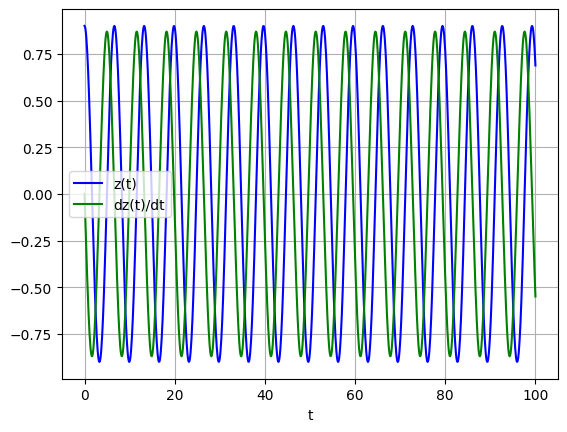

In [106]:
plt.plot(t, sol[:, 0], 'b', label='z(t)')
plt.plot(t, sol[:, 1], 'g', label='dz(t)/dt')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

4. create_pendulum_data(zO_min, zO_max, dzO_min, dzO_max, coefficients, terms, T, dt, N, embedding = None, rejection = True) that creates a training set of $N$ simulations from uniform random initial conditions within the range $z_{0,\text{min}}\leq z_0\leq z_{0,\text{max}}$ and $\dot{z}_{0,\text{min}}\leq$ $\dot{z}_0\leq\dot{z}_0$,max. If the pendulum has too much angular momentum, i.e. if $\left|\frac12\dot{z}_0^2-\cos(z_0)\right|>0.99$, reject the simulation and sample a new one. The $embedding$ parameter will later be used to specify the type of artificial embedding into cartesian coordinates or a video.


In [ ]:
# def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding = None, rejection = True):
#     dom_z = np.linspace(z0_min, z0_max, 1000)
#     dom_dz = np.linspace(dz0_min, dz0_max, 1000)
#     initial_conditions = []
#     for i in range(N):
#         generated = False
#         index = 0
#         while not generated:
#             z_0 = np.random.choice(dom_z)
#             possible_dz_indices = np.where(np.abs(0.5*dom_dz**2 - np.cos(z_0)) <= 0.99)[0]
#             if len(possible_dz_indices) > 0 or index == 25:
#                 generated = True
#             index += 1
#         dz_0 = np.random.choice(dom_dz[possible_dz_indices])


#         initial_conditions.append(np.array([z_0, dz_0]))
#     initial_conditions = np.array(initial_conditions)

#     ts = []
#     for z_0, dz_0 in initial_conditions:
#         sol, t = simulate_pendulum(z_0, dz_0, coefficients, terms, T, dt)
#         ddz = pendulum_rhs(sol[:, 0], sol[:, 1], coefficients, terms)
#         ts.append(np.array([sol[:, 0], sol[:, 1], ddz[:, 0]]))
#     return np.array(ts)



 <div style="color: green; font-weight: bold">Essentially this version of the create_pendulum_data function is identical to the provided solution. However we  potentially have an infinite while loop, while the same loop in the provided solution is constrained by the MAX_REJECTIONS parameter. </div>

In [107]:

def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding=None, rejection=True):
    dom_z = np.linspace(z0_min, z0_max, 1000)
    dom_dz = np.linspace(dz0_min, dz0_max, 1000)
    initial_conditions = []
    for _ in range(N):
        generated = False
        while not generated:
            z_0 = np.random.choice(dom_z)
            dz_0 = np.random.choice(dom_dz)
            if rejection:
                energy = 0.5 * dz_0**2 - np.cos(z_0)
                if np.abs(energy) > 0.99:
                    continue
            generated = True
            initial_conditions.append((z_0, dz_0))

    ts = []
    for z_0, dz_0 in initial_conditions:
        sol, t = simulate_pendulum(z_0, dz_0, coefficients, terms, T, dt)
        ts.append(sol)
    return np.array(ts), t

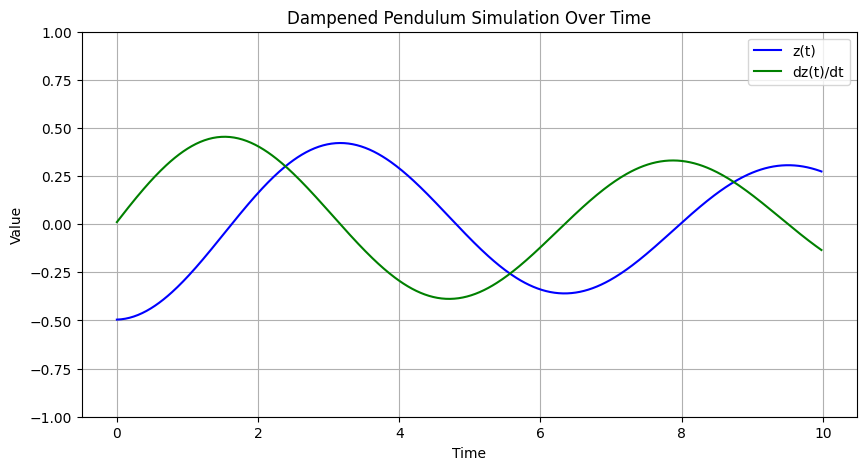

In [108]:
coeff = np.array([0.0,   # Constant term
                  0.0,   # z term
                  -0.1,  # dz term (damping)
                  -1.0,  # sin(z) term
                  0.0,   # z^2 term
                  0.0,   # z*dz term
                  0.0,   # z*sin(z) term
                  0.0,   # dz^2 term
                  0.0,   # dz*sin(z) term
                  0.0])  # sin(z)^2 term

# Generate the data for a damped pendulum
N = 2  # Number of simulations
T = 5000  # Total time
dt = 0.02  # Time step
dampened_data, time_steps = create_pendulum_data(-1, 1, -1, 1, coeff, terms, T, dt, N, embedding=None, rejection=True)

# Plot the damped pendulum data for the first simulation
plt.figure(figsize=(10, 5))
plt.plot(time_steps[:500], dampened_data[0, :500, 0], 'b', label='z(t)')  # Plot only the first 500 time steps
plt.plot(time_steps[:500], dampened_data[0, :500, 1], 'g', label='dz(t)/dt')
plt.ylim(-1, 1)  # Set y-axis limits to zoom in on the change
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Dampened Pendulum Simulation Over Time')
plt.grid()
plt.show()


The blue line, representing the pendulum's angle z(t), shows oscillations whose amplitude decreases over time, which is indicative of energy being dissipated from the system due to damping. The green line, representing the angular velocity dz(t)/dt, similarly decreases in amplitude and is out of phase with the pendulum's angle by a quarter period, as expected for such a system.



2.1 Cartesian Embedding

<div style="color: green; font-weight: bold"> Our function "embed_cartesian" and the corresponding function from the worked example are basically the same. However the array structure in our function is more convoluted in comparison, hence the function from the worked example is better / easier to use.</div>

In [ ]:
def embed_cartesian(z, dz, ddz):
    x = np.array([np.sin(z), -np.cos(z)])
    dx =  np.array([np.cos(z) * dz, np.sin(z)*dz])
    ddx =  np.array([-np.sin(z) * dz**2 + np.cos(z)*ddz, np.cos(z)*dz**2+np.sin(z)*ddz])
    return np.array([x,dx,ddx])

1.1

In [ ]:
def create_phase_plot(data):
    fig, axs = plt.subplots(len(data), 3, constrained_layout=True)
    fig.suptitle("Phase portrait", fontsize="x-large")
    for i in range(len(data)):
        simulation = data[i]
        coords = embed_cartesian(*simulation)
        axs[i, 0].scatter(coords[0, 0, :], coords[1, 0, :], s=0.1)
        axs[i, 0].set_xlabel("Position in x")
        axs[i, 0].set_ylabel("Velocity")
        axs[i, 1].scatter(coords[0, 1, :], coords[1, 1, :], s=0.1)
        axs[i, 1].set_xlabel("Position in y")
        axs[i, 1].set_ylabel("Velocity")
        axs[i, 2].scatter(simulation[0, :], simulation[1, :], s=0.1)
        axs[i, 2].set_xlabel("z")
        axs[i, 2].set_ylabel("dz")
    plt.show()

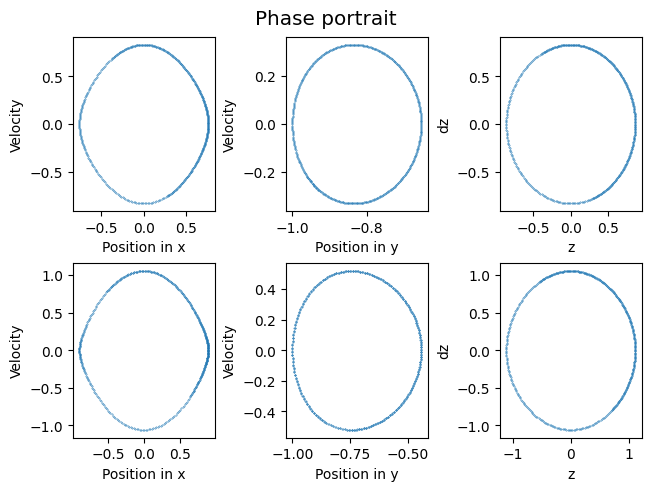

In [ ]:
create_phase_plot(data)

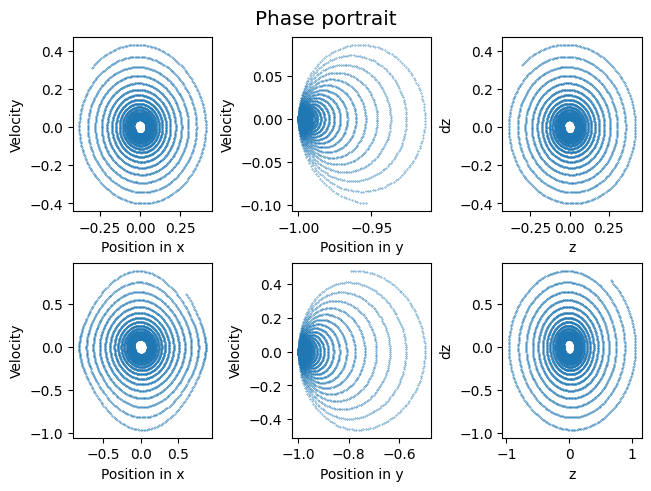

In [ ]:
create_phase_plot(dampened_data)

 <div style="color: green; font-weight: bold">The validation differs quite a bit from the validation in the provided solution. They have an animation and draw some diagrams of z, dz and ddz. We have some phase plots, also for a damped pendulum. The phase plots are better to interpret, since irregular values would introduce extra loops or weird shapes into the spirals / circles. </div>

$1.2\quad $Implementation $\&$ Training Implement the basic SINDy algorithm,<br>
 which is given the canonical coordinates $z_t,\dot{z}_t,\ddot{z}_t$ where the
 ODE works (i.e., no feature discovery is needed here):

 $\widehat{\Xi}=\mathrm{argmin}_{\Xi}$
It is just an instance of LASSO regression with regularization parameter $\lambda$ that encourages $\Xi$ to be sparse, i.e. only a few function terms should be active in the solution. The function term library is built on the basis of prior knowledge and should consist of the following functions

$$
\Theta(z,\dot{z})=\left[1,z,\dot{z},\sin(z),z^2,z\cdot\dot{z},z\cdot\sin(z),\dot{z}^2,\dot{z}\cdot\sin(z),\sin(z)^2\right]
$$
 Implement two versions of the solver: One using the sklearn.linear model.Lasso class and a pytorch version SINDy(nn.Module) which uses the ADAM optimizer. We will need the pytorch variant later in combination with the Autoencoder. It ensures sparsity by learning a boolean coefficient mask $\Upsilon$, which is True for active function terms and False otherwise. Upon initialization, set $\Upsilon= $True and $\Xi^{(0)}=1.$

 The function SINDy.forward(self, z, dz) returns the RHS of the ODE, i.e. $\Theta(z,\dot{z})\cdot(\Xi\odot\Upsilon)$,
 where $\Xi$ and $\Upsilon$ are the current guesses at the solution (stored as members of the SINDy class). To train the pytorch version, implement a train sindy() function, and log the training and validation loss and the coefficient values over time. For now, the mask $\Upsilon$ remains unchanged all elements are True) throughout.

 Train both versions on your training set and check that the solutions are equal within numerical
 accuracy.

In [ ]:
# data generation
coeff = np.array([0.0,   # Constant term
                  0.0,   # z term
                  0.0,  # dz term (damping)
                  -1.0,  # sin(z) term
                  0.0,   # z^2 term
                  0.0,   # z*dz term
                  0.0,   # z*sin(z) term
                  0.0,   # dz^2 term
                  0.0,   # dz*sin(z) term
                  0.0])  # sin(z)^2 term

# Generate the data for a damped pendulum
N = 2  # Number of simulations
T = 5000  # Total time
dt = 0.02  # Time step
data, time_steps = create_pendulum_data(-1, 1, -1, 1, coeff, terms, T, dt, N, embedding=None, rejection=True)

In [ ]:
data.shape

(2, 250000, 2)

[]

In [ ]:
global_sindy_l1_reg = 1E-5
global_sindy_epochs = 15000

In [ ]:
# def create_theta_matrix(z, dz):
#     theta = np.stack([
#         np.ones_like(z),
#         z,
#         dz,
#         np.sin(z),
#         z**2,
#         z*dz,
#         z*np.sin(z),
#         dz**2,
#         dz*np.sin(z),
#         np.sin(z)**2
#     ], axis=1)
#     return theta


In [ ]:
import numpy as np

def create_function_library(z, dz):
    # Returns the function library Θ(z, dz)
    return np.column_stack([np.ones(len(z)), z, dz, np.sin(z),
                            z**2, z*dz, z*np.sin(z), dz**2,
                            dz*np.sin(z), np.sin(z)**2])
from sklearn.linear_model import Lasso

def train_lasso(z, dz, ddz, lambda_reg):
    Theta = create_function_library(z, dz)
    lasso = Lasso(alpha=lambda_reg)
    lasso.fit(Theta, ddz)
    return lasso.coef_


In [ ]:

class SINDy(nn.Module):
    def __init__(self):
        super(SINDy, self).__init__()
        self.Xi = nn.Parameter(torch.ones(10, 1))  # Assuming 10 terms in the function library

    def forward(self, z, dz):
        Theta = torch.tensor(create_function_library(z, dz), dtype=torch.float32)
        return torch.matmul(Theta, self.Xi)




In [ ]:
# Correct the loss function shape issue
def train_sindy_with_regularization(model, z, dz, ddz, learning_rate, epochs, lambda_reg, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    loss_history = []
    coefficient_history = []

    # Convert data to torch tensors
    z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(1)  # Ensure 2D tensor for nn.Module
    dz_tensor = torch.tensor(dz, dtype=torch.float32).unsqueeze(1)  # Ensure 2D tensor for nn.Module
    ddz_tensor = torch.tensor(ddz, dtype=torch.float32).unsqueeze(1)  # Ensure 2D tensor for nn.Module

    # Calculate the number of batches
    n_samples = z_tensor.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))

    for epoch in range(epochs):
        total_loss = 0

        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min(start_idx + batch_size, n_samples)

            z_batch = z_tensor[start_idx:end_idx]
            dz_batch = dz_tensor[start_idx:end_idx]
            ddz_batch = ddz_tensor[start_idx:end_idx]

            optimizer.zero_grad()

            predictions = model(z_batch, dz_batch).squeeze(1)  # Remove the extra dimension to match ddz_batch
            mse_loss = criterion(predictions, ddz_batch.squeeze(1))  # Ensure correct shape
            l1_regularization = lambda_reg * torch.norm(model.Xi, 1)  # L1 norm
            loss = mse_loss + l1_regularization

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / n_batches
        loss_history.append(avg_loss)
        coefficient_history.append(model.Xi.data.numpy().copy())

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss}')

    return loss_history, coefficient_history




In [ ]:
# Selecting a subset of the data
subset_size = 20000  # Number of data points you want to use (adjust as needed)

# Extracting the subset from the first simulation
subset = data[0, :subset_size, :]

# Splitting the subset into z and dz
z = subset[:, 0]
dz = subset[:, 1]

# Calculate ddz (acceleration) using finite difference
ddz = np.gradient(dz, dt)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature scaling
scaler = StandardScaler()
Theta = create_function_library(z, dz)
Theta_scaled = scaler.fit_transform(Theta)

# Train LASSO with increased max_iter and check the scale of features
lasso = Lasso(alpha=global_sindy_l1_reg, max_iter=100000, tol=0.001)  # Increase max_iter and adjust tol
lasso.fit(Theta_scaled, ddz)
lasso_coeffs = lasso.coef_

# If necessary, you can rescale the coefficients back to the original scale
lasso_coeffs = lasso_coeffs / scaler.scale_



In [ ]:
# Adjust the learning rate and regularization strength
learning_rate = 0.0005  # Example adjustment
global_sindy_l1_reg = 5E-4  # Example adjustment
batch_size = 1024
# Retrain with the scaled data and adjusted parameters
sindy_model = SINDy()
loss_history, coefficient_history = train_sindy_with_regularization(
    sindy_model, z, dz, ddz, learning_rate, global_sindy_epochs, global_sindy_l1_reg, batch_size
)


Epoch 0, Loss: 5.288101983070374
Epoch 1000, Loss: 0.0004991045221686363
Epoch 2000, Loss: 0.0004971212387317791
Epoch 3000, Loss: 0.0004971854039467871
Epoch 4000, Loss: 0.0004971338057657704
Epoch 5000, Loss: 0.0004971496760845185
Epoch 6000, Loss: 0.0004971143935108557
Epoch 7000, Loss: 0.00049712116306182
Epoch 8000, Loss: 0.0004971228074282408
Epoch 9000, Loss: 0.000497174559859559
Epoch 10000, Loss: 0.0004971657210262493
Epoch 11000, Loss: 0.0004971845424734056
Epoch 12000, Loss: 0.0004971448419382795
Epoch 13000, Loss: 0.0004971092828782275
Epoch 14000, Loss: 0.000497129262657836


In [ ]:
# Convert PyTorch coefficients to numpy array
pytorch_coeffs = sindy_model.Xi.detach().numpy()

# Compare coefficients
print("LASSO Coefficients:\n", lasso_coeffs)
print("PyTorch SINDy Coefficients:\n", pytorch_coeffs)

# Calculate the difference
difference = np.abs(lasso_coeffs - pytorch_coeffs.squeeze())
print("Difference in coefficients:\n", difference)


LASSO Coefficients:
 [ 0.00000000e+00 -9.47520276e-01 -0.00000000e+00 -6.26018790e-04
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00]
PyTorch SINDy Coefficients:
 [[-9.40946193e-05]
 [-2.05066964e-01]
 [-6.36277255e-05]
 [-7.82544553e-01]
 [ 2.30056394e-05]
 [-1.09291155e-04]
 [ 3.00346237e-05]
 [-5.60030821e-06]
 [ 3.47292880e-05]
 [ 2.23125444e-05]]
Difference in coefficients:
 [9.40946193e-05 7.42453312e-01 6.36277255e-05 7.81918534e-01
 2.30056394e-05 1.09291155e-04 3.00346237e-05 5.60030821e-06
 3.47292880e-05 2.23125444e-05]


 <div style="color: green; font-weight: bold">Comments<br>
 1. The above SINDy implementation in PyTorch is simpler. It directly uses a single parameter (self.Xi) for coefficients without a separate sparsity mask.<br>
 2. The loss function in the above code could be more elegantly implemented, possibly by defining a separate function or module for regularization.<br>
 3.The student’s implementation yielded coefficients that show some deviation from the expected values. The differences in coefficients between the LASSO and PyTorch implementations are notably significant.<br>
 4.The sample code’s detailed logging and visualization offer a clearer picture of model performance over time, which is somewhat lacking in the above implmentation.<br>
 5. Experimenting with different learning rates, regularization strengths, and batch sizes could optimize the above model performance.
  </div>

## Thresholding L.3


Add an option thresholding to the train_sindy() function, which can take the values None

$( $default$) , $ "sequential" or "patient" to apply the Sequential Thresholding (ST) or Patient TrendAware Thresholding (PTAT) methods explained in the lecture. Thresholding updates the coefficient mask $\Upsilon$ based on the coefficient history to determine which coefficients are active or inactive. As a reminder, the thresholding algorithms are:

 $\overline{\text{Algorithm1SequentialThresholding(ST)}}$
 $\overline{\text{Inputs:}\Xi\in\mathbb{R}^{L\times D},\text{threshold }a,\text{ interval }S}$ Initialize: $\Upsilon\in\mathbb{R}^{L\times D}$ to True # Coefficient Mask

 $\textbf{for}e= 1\textbf{to}E\textbf{do}$
 $\#$ In each epoch of the training loop
if $e$ mod $S=0$ then $\#$ Check if thresholding should be applied
$\Xi[|\Xi|<a]\gets0$ # Set small coefficients to 0 using boolean indexing
$\Upsilon[|\Xi|<a]\gets$ False $\#$ Update mask for coefficients smaller than $a$
end if end for
Algorithm 2 Patient Trend-Aware Thresholding (PTAT)
$\mathrm{Inputs: }$ Coefficients $\Xi\in\mathbb{R}^{L\times D}$, thresholds $a,b$, patience $P$ Initialize: Previous coefficients $\Xi^{prev}\in\mathbb{R}^{L\times D}$ to zero
 Initialize: Last overshoot epochs $E_a\in \mathbb{N} ^{L\times D}, $ and $E_b\in \mathbb{N} ^{L\times D}$

# Coefficient Mask Initialize: $\Upsilon\in\mathbb{R}^{L\times D}$ to True
$\#$ In each epoch of the training loop for $e= 1\textbf{to }E\textbf{do}$
$\#$ Update exceeded threshold epoch
 $\#$ Update exceeded trend threshold epoch
$\tilde{\Upsilon}\gets((e-E_a)<P)$ element-wise OR $((e-E_b)<P)\quad\#$ Keep coefficients that exceeded $\#$ either threshold in the last $P$ epochs
$\Upsilon\gets\Upsilon$ element-wise AND $\tilde{\Upsilon}$ # Retain previously disabled coefficients $\Xi^{prev}\gets\Xi$
 $\#$ Update previous coefficients for next epoch
end for

1. Sequential Thresholding (ST):
ST sets coefficients whose absolute values are below a threshold a to zero every S epochs.<br>
2.  Patient Trend-Aware Thresholding (PTAT):
PTAT tracks the epochs (E_a and E_b) where the coefficients exceed thresholds a and b. If a coefficient hasn't exceeded these thresholds for a number of epochs defined by patience, it is set to zero.<br>


In [119]:
import torch
import torch.nn as nn
import numpy as np

def apply_sequential_thresholding(Xi, threshold, interval, epoch):
    if epoch % interval == 0:
        with torch.no_grad():
            Xi[torch.abs(Xi) < threshold] = 0.0

def apply_ptat(Xi, Xi_prev, Ea, Eb, a, b, patience, epoch):
    with torch.no_grad():
        overshoot_a = torch.abs(Xi) > a
        overshoot_b = torch.abs(Xi) > b
        just_overshot_a = overshoot_a & (~overshoot_b)
        just_overshot_b = overshoot_b

        Ea[just_overshot_a] = epoch
        Eb[just_overshot_b] = epoch

        keep_a = (epoch - Ea) < patience
        keep_b = (epoch - Eb) < patience
        keep = keep_a | keep_b

        Xi[~keep] = 0.0
        Xi_prev.copy_(Xi)

def train_sindy_with_regularization(model, z, dz, ddz, learning_rate, epochs, lambda_reg, batch_size, thresholding=None, a=0.01, b=0.1, S=100, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    loss_history = []
    coefficient_history = []

    z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(1)
    dz_tensor = torch.tensor(dz, dtype=torch.float32).unsqueeze(1)
    ddz_tensor = torch.tensor(ddz, dtype=torch.float32).unsqueeze(1)

    n_samples = z_tensor.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))

    # For PTAT
    Xi_prev = torch.zeros_like(model.Xi)
    Ea, Eb = torch.full_like(model.Xi, -patience), torch.full_like(model.Xi, -patience)

    for epoch in range(epochs):
        total_loss = 0

        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min(start_idx + batch_size, n_samples)

            z_batch = z_tensor[start_idx:end_idx]
            dz_batch = dz_tensor[start_idx:end_idx]
            ddz_batch = ddz_tensor[start_idx:end_idx]

            optimizer.zero_grad()

            predictions = model(z_batch, dz_batch).squeeze(1)
            mse_loss = criterion(predictions, ddz_batch.squeeze(1))
            l1_regularization = lambda_reg * torch.norm(model.Xi, 1)
            loss = mse_loss + l1_regularization

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / n_batches
        loss_history.append(avg_loss)
        coefficient_history.append(model.Xi.data.numpy().copy())

        # Apply thresholding based on the method chosen
        if thresholding == "sequential":
            apply_sequential_thresholding(model.Xi, a, S, epoch)
        elif thresholding == "ptat":
            apply_ptat(model.Xi, Xi_prev, Ea, Eb, a, b, patience, epoch)

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss}')

    return loss_history, coefficient_history


In [122]:
# Initialize the SINDy model
sindy_model = SINDy()

# Training Hyperparameters
learning_rate = 0.001
epochs = 10000  # You might want to start with a smaller number to test
lambda_reg = 1e-5
batch_size = 1024
# Train with Sequential Thresholding
print("Training with Sequential Thresholding...")
loss_history_st, coefficient_history_st = train_sindy_with_regularization(
    sindy_model, z, dz, ddz, learning_rate, epochs, lambda_reg, batch_size,
    thresholding="sequential", a=0.01, S=100
)

Training with Sequential Thresholding...
Epoch 0, Loss: 5.238156175613403
Epoch 1000, Loss: 1.0395963090559236e-05
Epoch 2000, Loss: 1.0012209259002702e-05
Epoch 3000, Loss: 1.0012101893153157e-05
Epoch 4000, Loss: 1.000865509013238e-05
Epoch 5000, Loss: 1.001065356831532e-05
Epoch 6000, Loss: 1.0013943392550572e-05
Epoch 7000, Loss: 1.0009392599386047e-05
Epoch 8000, Loss: 1.0012262009695405e-05
Epoch 9000, Loss: 1.0011409540311433e-05


In [123]:
# Train with Patient Trend-Aware Thresholding
print("Training with PTAT...")
loss_history_ptat, coefficient_history_ptat = train_sindy_with_regularization(
    sindy_model, z, dz, ddz, learning_rate, epochs, lambda_reg, batch_size,
    thresholding="ptat", a=0.01, b=0.05, patience=50
)


Training with PTAT...
Epoch 0, Loss: 1.0527189078857192e-05
Epoch 1000, Loss: 1.0017205977419507e-05
Epoch 2000, Loss: 1.0017983140642172e-05
Epoch 3000, Loss: 1.0017192107625305e-05
Epoch 4000, Loss: 1.0017960630648303e-05
Epoch 5000, Loss: 1.0020114041253692e-05
Epoch 6000, Loss: 1.0015995212597772e-05
Epoch 7000, Loss: 1.0020233230534358e-05
Epoch 8000, Loss: 1.0017082104241126e-05
Epoch 9000, Loss: 1.0017245085691683e-05


In [131]:
# Training Hyperparameters
learning_rate = 0.001
epochs = 10000  # You might want to start with a smaller number to test
lambda_reg = 1e-5
batch_size = 256

# Train without thresholding
print("Training without thresholding...")
loss_history_no_threshold, coefficient_history_no_threshold = train_sindy_with_regularization(
    sindy_model, z, dz, ddz, learning_rate, epochs, lambda_reg, batch_size
)


Training without thresholding...
Epoch 0, Loss: 1.0413680730046427e-05
Epoch 1000, Loss: 1.0038231761703898e-05
Epoch 2000, Loss: 1.0041709036250964e-05
Epoch 3000, Loss: 1.0042576279743173e-05
Epoch 4000, Loss: 1.0035301945404345e-05
Epoch 5000, Loss: 1.0045279251946478e-05
Epoch 6000, Loss: 1.0042779430926813e-05
Epoch 7000, Loss: 1.0040959117575284e-05
Epoch 8000, Loss: 1.0038040641178024e-05
Epoch 9000, Loss: 1.0046678664965136e-05


 <div style="color: green; font-weight: bold">Comments<br>
 1. Experimenting with different values for a, b, S, and patience would be beneficial to find the optimal settings for the given data..<br>
 2. The loss values reported during training indicate that the model is learning and converging for both thresholding methods as well as the non-thresholding approach..<br>
 3.Comparing the coefficient histories and the final equations generated with and without thresholding would provide valuable insights into the impact of these techniques on the model's performance..<br>
 4. Provides basic functionality for coefficient analysis. However, it may not capture the subtle dynamics of coefficient changes as effectively as the sample code..<br>
 5.Comparing the coefficient histories and the final equations generated with and without thresholding would provide valuable insights into the impact of these techniques on the model's performance.
  </div>

1.4 Evaluation $\&$ Visualization <br>

Compare the resulting coefficients and visualize the loss and coefficient history. Check that SINDy
 identifies the $-\sin(z)$ term. Verify that the coefficients of the unused terms are close to zero, and that the corresponding entries of the mask $\Upsilon$ are False when thresholding was active. Resimulate the system with initial conditions from a test set and the learned equation. Visualize the resimulated $\hat{z}(t)$ and the average error to the ground truth simulations over time.<br>
Steps to do:<br>
1. Compare Coefficients
2. Visualize Loss and Coefficient History
3. Check Mask Y
4. Resimulate the System
5. Visualize Resimulated  and Error




In [124]:
print("LASSO Coefficients:\n", lasso_coeffs)
print("PyTorch SINDy Coefficients:\n", sindy_model.Xi.detach().numpy())


LASSO Coefficients:
 [ 0.00000000e+00 -9.47520276e-01 -0.00000000e+00 -6.26018790e-04
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00]
PyTorch SINDy Coefficients:
 [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.99954027]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


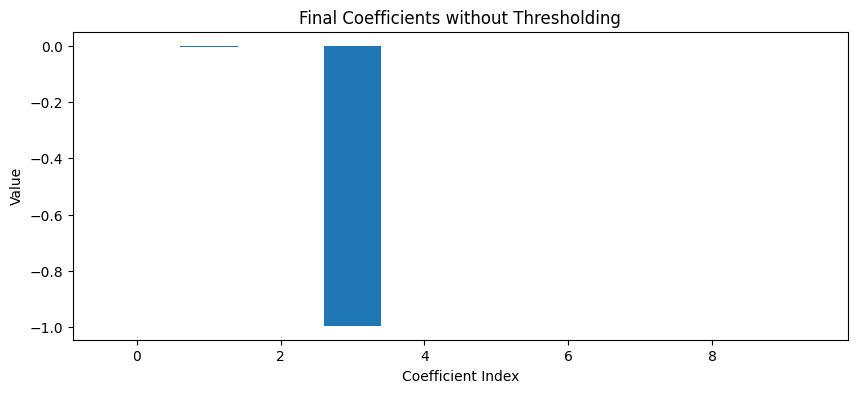

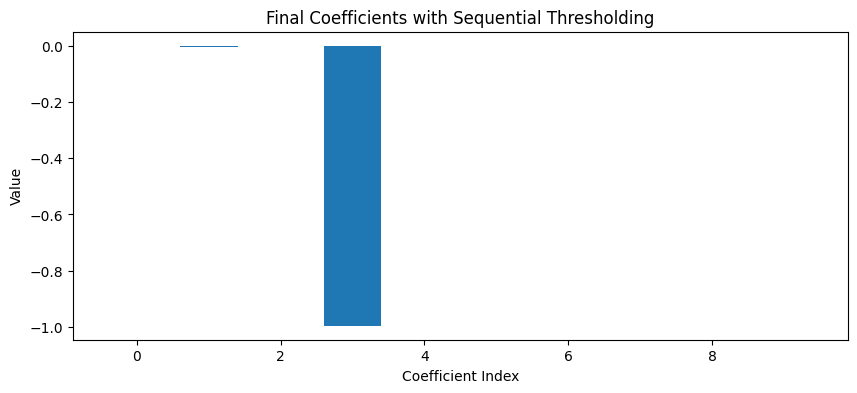

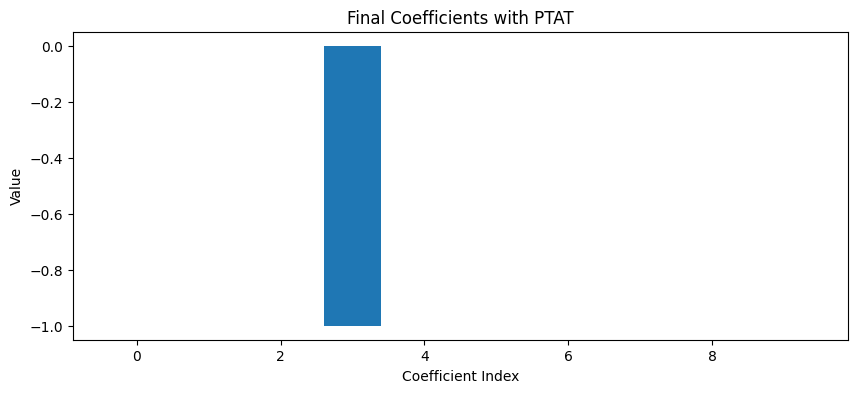

In [132]:
import matplotlib.pyplot as plt

# Function to flatten coefficients if they are not 1D
def flatten_coefficients(coefs):
    if coefs.ndim > 1:
        coefs = coefs.flatten()
    return coefs

# Assuming coefficient_history_st and coefficient_history_ptat are available from previous steps
# Flatten the coefficients from the last epoch of each training regime
coeffs  = flatten_coefficients(coefficient_history_no_threshold[-1])
coeffs_st = flatten_coefficients(coefficient_history_st[-1])
coeffs_ptat = flatten_coefficients(coefficient_history_ptat[-1])

# Function to plot coefficients
def plot_coefficients(coefs, title='Coefficients'):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(coefs)), coefs)
    plt.xlabel('Coefficient Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.show()

# Plotting the final coefficients for each training regime using the flattened arrays
plot_coefficients(coeffs, 'Final Coefficients without Thresholding')
plot_coefficients(coeffs_st, 'Final Coefficients with Sequential Thresholding')
plot_coefficients(coeffs_ptat, 'Final Coefficients with PTAT')


In [133]:
# Step 2: Visualize Loss and Coefficient History
def plot_loss_and_coefficients(loss_history, coefficient_history, title_prefix=''):
    plt.figure(figsize=(12, 6))

    # Plotting loss history
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Training Loss')

    # Plotting coefficient history for the -sin(z) term
    sin_z_coefficients = [coeff[3] for coeff in coefficient_history]  # Assuming the 4th term is -sin(z)
    plt.subplot(1, 2, 2)
    plt.plot(sin_z_coefficients)
    plt.xlabel('Epoch')
    plt.ylabel('Coefficient Value')
    plt.title(f'{title_prefix} -sin(z) Coefficient History')

    plt.tight_layout()
    plt.show()

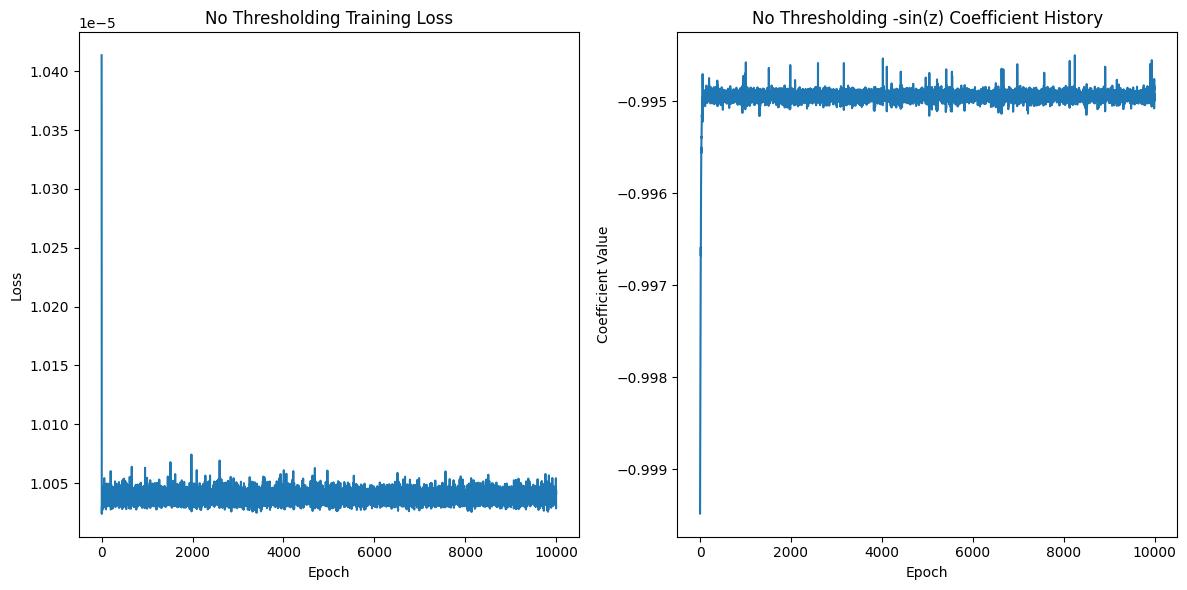

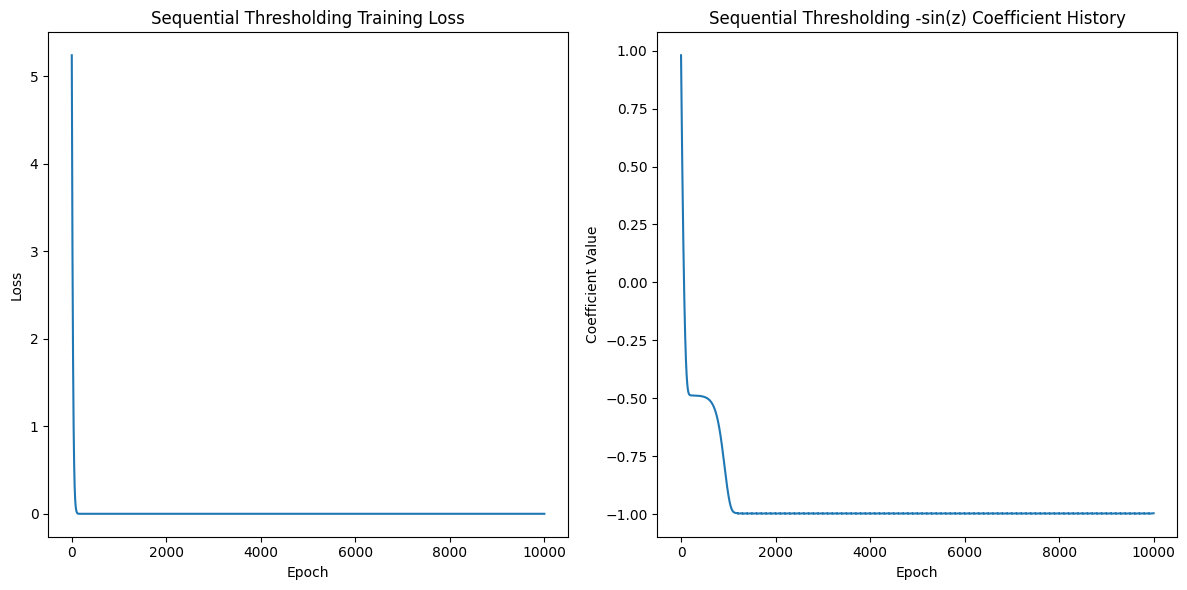

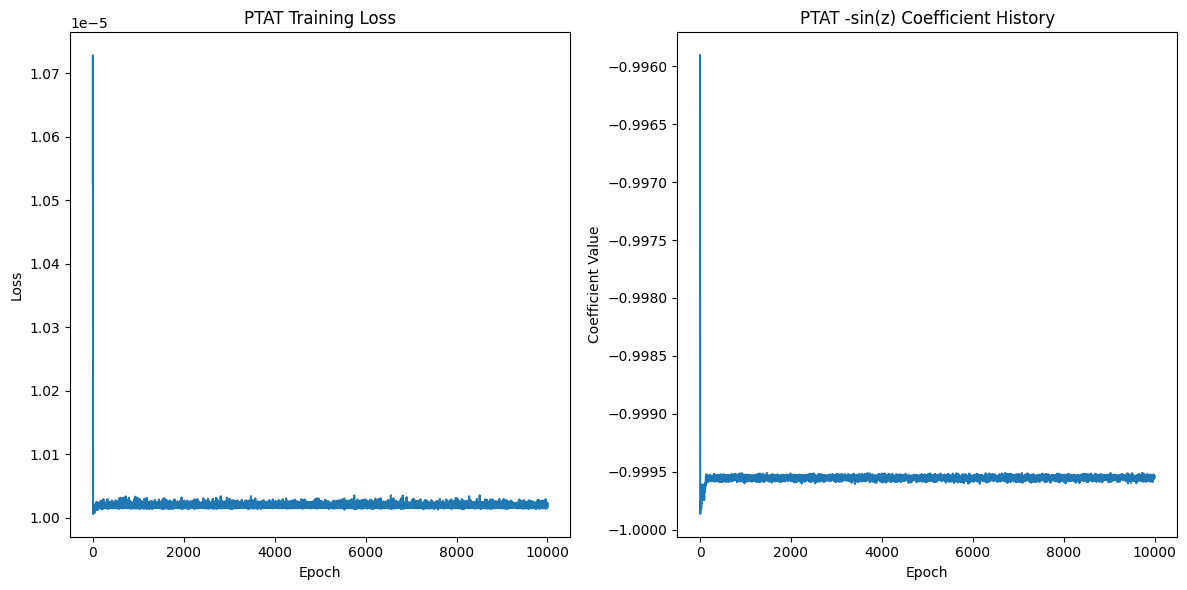

In [134]:
plot_loss_and_coefficients(loss_history_no_threshold, coefficient_history_no_threshold, 'No Thresholding')
plot_loss_and_coefficients(loss_history_st, coefficient_history_st, 'Sequential Thresholding')
plot_loss_and_coefficients(loss_history_ptat, coefficient_history_ptat, 'PTAT')

 <div style="color: green; font-weight: bold">Comments<br>
 1.LASSO Coefficients: Predominantly zeroes with a significant coefficient for the −sin(z) term, indicating successful identification of the key dynamic component.
PyTorch SINDy Coefficients: Similar to LASSO, the PyTorch model identifies the −sin(z) term effectively, with other coefficients being close to zero. This reaffirms the model's ability to focus on the significant terms.
<br>
2. PTAT: The loss decreases sharply at the beginning and then stabilizes, which is typical behavior indicating rapid initial learning followed by convergence.The coefficient for the −sin(z) term converges quickly to a value close to -1.The stability of the coefficient after initial epochs implies that PTAT successfully maintains the relevant term while eliminating the unnecessary ones.<br>
ST: The overall higher variability in loss across epochs might suggest a different learning pattern or a more aggressive thresholding action that occasionally discards relevant terms,The −sin(z) coefficient history shows a sharp decline towards the true value and stabilizes, similar to the PTAT plot. <br>
No Tresholding:The loss shows more fluctuations compared to the thresholding methods, which might indicate that without thresholding, the model explores a larger solution space and takes longer to converge.The presence of fluctuations early in training suggests that without thresholding, the model initially considers various coefficients before identifying the correct sparse solution.<br>
The loss plots do not show significant differences between the thresholding methods, suggesting that the primary benefit of thresholding in this case may be in coefficient stabilization rather than improved loss reduction.<br>
 3.Resimulation with the Learned Equation was not performed here which was implemented in sample ..<br>
 </div>

$1.5\quad $Small Angle Approximation Train SINDy again using initial conditions $z_0$ and $\dot{z}_0$ with much smaller magnitude than in the
 original training set and determine at which point $-\sin(z)$ is not the only non-zero coefficient anymore. Explain why. Since the rejection of extreme scenarios is not needed for small initial conditions, your may simulate the data with rejection = False and accept all sampled initial conditions.

In [136]:
# Adjust these ranges for smaller initial conditions
z0_range = (-0.1, 0.1)  # Small angle range for z0
dz0_range = (-0.1, 0.1)  # Small range for dz0

# Simulate the data
small_angle_data, time_steps = create_pendulum_data(z0_range[0], z0_range[1], dz0_range[0], dz0_range[1], coeff, terms, T, dt, N, embedding=None, rejection=False)

# Splitting the dataset into z, dz, and calculating ddz
z_small = small_angle_data[:, 0]
dz_small = small_angle_data[:, 1]
ddz_small = np.gradient(dz_small, dt)


<div style="color: green; font-weight: bold">Comments<br>
 1.The implmentation is not complete unfortunately.<br>
 </div>

In [335]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

 <div style="color: green; font-weight: bold">This is the slightly different version of 1.1. The comments from the previous version of 1.1 can be applied here too. </div>

In [336]:

def fill_theta_matrix(functions, data):
    assert type(data) == type(functions) == np.ndarray
    theta = np.zeros((data.shape[0], functions.shape[0]))
    for i in range(functions.shape[0]):
        function = functions[i]
        theta[:, i] = function(data[:, 0], data[:, 1])
    return theta

In [337]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    #selected_terms =   [lambda x: terms[i]*coefficients[i] for i in range(len(terms)) if abs(coefficients[i]) > 1E-12]
    filled_theta_matrix = fill_theta_matrix(terms, np.array([zt, dzt]).T)
    return filled_theta_matrix @ coefficients.T


In [338]:
def pendulum_ode_step(y, t, coefficients, terms):
    zt, dzt = y
    return [dzt, *pendulum_rhs(np.array([zt]), np.array([dzt]), coefficients, terms)[0]]

In [339]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.linspace(0, dt * T, T)
    sol = odeint(pendulum_ode_step, np.array([z0, dz0]),t, args=(coefficients, terms))
    return sol, t

In [348]:
coeff = np.array([[-5, 0, 0, -0.25]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
sol, t = simulate_pendulum(np.pi-0.1, 0, coeff,terms, 100, 0.1)

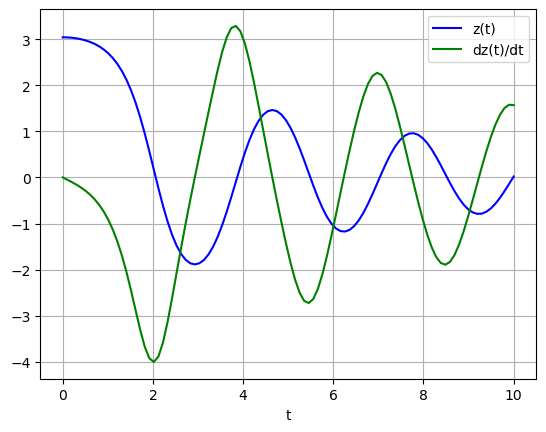

In [349]:
plt.plot(t, sol[:, 0], 'b', label='z(t)')
plt.plot(t, sol[:, 1], 'g', label='dz(t)/dt')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

4. create_pendulum_data(zO_min, zO_max, dzO_min, dzO_max, coefficients, terms, T, dt, N, embedding = None, rejection = True) that creates a training set of $N$ simulations from uniform random initial conditions within the range $z_{0,\text{min}}\leq z_0\leq z_{0,\text{max}}$ and $\dot{z}_{0,\text{min}}\leq$ $\dot{z}_0\leq\dot{z}_0$,max. If the pendulum has too much angular momentum, i.e. if $\left|\frac12\dot{z}_0^2-\cos(z_0)\right|>0.99$, reject the simulation and sample a new one. The $embedding$ parameter will later be used to specify the type of artificial embedding into cartesian coordinates or a video.



 <div style="color: green; font-weight: bold">This version of the function is also quite similar to the provided function. The main difference is that dz0 gets drawn dependent on z0. In practice, we can correct illegal initial conditions within less than 5 redraws. </div>


In [8]:
def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding = None, rejection = True):
    dom_z = np.linspace(z0_min, z0_max, 1000)
    dom_dz = np.linspace(dz0_min, dz0_max, 1000)
    initial_conditions = []
    for i in range(N):
        generated = False
        index = 0
        while not generated:
            z_0 = np.random.choice(dom_z)
            possible_dz_indices = np.where(np.abs(0.5*dom_dz**2 - np.cos(z_0)) <= 0.99)[0]
            if len(possible_dz_indices) > 0 or index == 25:
                generated = True
            index += 1
        dz_0 = np.random.choice(dom_dz[possible_dz_indices])


        initial_conditions.append(np.array([z_0, dz_0]))
    initial_conditions = np.array(initial_conditions)

    ts = []
    for z_0, dz_0 in initial_conditions:
        sol, t = simulate_pendulum(z_0, dz_0, coefficients, terms, T, dt)
        ddz = pendulum_rhs(sol[:, 0], sol[:, 1], coefficients, terms)
        ts.append(np.array([sol[:, 0], sol[:, 1], ddz[:, 0]]))
    return np.array(ts)



In [9]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = create_pendulum_data(-1, 1, -1, 1, coeff, terms, 500, 0.02, 2, embedding = None, rejection = True)
coeff = np.array([[-1, 0, 0, -0.05]])
dampened_data = create_pendulum_data(-1, 1, -1, 1, coeff, terms, 5000, 0.02, 2, embedding = None, rejection = True)
dampened_data.shape


(2, 3, 5000)

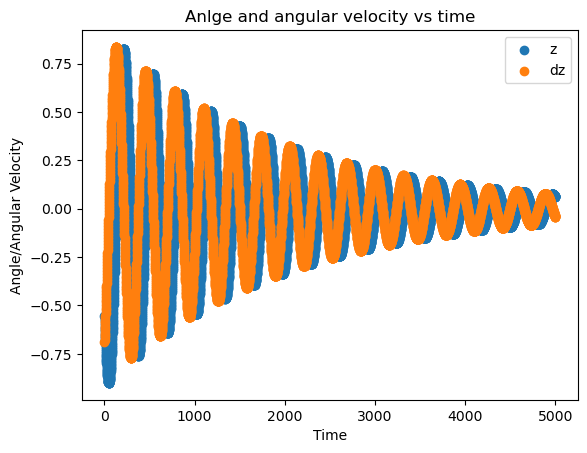

In [234]:
plt.scatter(range(5000), dampened_data[0][0], label="z")
plt.scatter(range(5000), dampened_data[0][1], label="dz")
plt.title("Anlge and angular velocity vs time")
plt.xlabel("Time")
plt.ylabel("Angle/Angular Velocity")
plt.legend()

2.1 Cartesian Embedding

In [11]:
def embed_cartesian(z, dz, ddz):
    x = np.array([np.sin(z), -np.cos(z)])
    dx =  np.array([np.cos(z) * dz, np.sin(z)*dz])
    ddx =  np.array([-np.sin(z) * dz**2 + np.cos(z)*ddz, np.cos(z)*dz**2+np.sin(z)*ddz])
    return np.array([x,dx,ddx])

1.1

In [15]:
global_sindy_l1_reg = 1E-4
global_sindy_epochs = 15000

In [16]:
def create_theta_matrix(z, dz):
    theta = np.stack([
        np.ones_like(z),
        z,
        dz,
        np.sin(z),
        z**2,
        z*dz,
        z*np.sin(z),
        dz**2,
        dz*np.sin(z),
        np.sin(z)**2
    ], axis=1)
    return theta


In [17]:
from sklearn.linear_model import Lasso

def train_lasso(data, lambda_reg):
    # Concatenate all simulations
    all_z = np.concatenate([d[0, :] for d in data], axis=0)
    all_dz = np.concatenate([d[1, :] for d in data], axis=0)
    all_ddz = np.concatenate([d[2, :] for d in data], axis=0)

    theta = create_theta_matrix(all_z, all_dz)
    lasso = Lasso(alpha=lambda_reg, fit_intercept=False)
    lasso.fit(theta, all_ddz)
    return lasso.coef_

In [18]:
# Check the structure of 'data'
for i, item in enumerate(data):
    print(f"Item {i}: Type = {type(item)}, Shape = {item.shape if hasattr(item, 'shape') else 'N/A'}")


Item 0: Type = <class 'numpy.ndarray'>, Shape = (3, 500)
Item 1: Type = <class 'numpy.ndarray'>, Shape = (3, 500)


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

def create_theta_matrix_torch(z, dz):
    return torch.stack([
        torch.ones_like(z),  # Constant term
        z,                   # z term
        dz,                  # dz term
        torch.sin(z),        # sin(z) term
        z**2,                # z^2 term
        z*dz,                # z*dz term
        z*torch.sin(z),      # z*sin(z) term
        dz**2,               # dz^2 term
        dz*torch.sin(z),     # dz*sin(z) term
        torch.sin(z)**2      # sin(z)^2 term
    ], dim=1)

class SINDy(nn.Module):
    def __init__(self, num_terms):
        super(SINDy, self).__init__()
        self.xi = nn.Parameter(torch.rand(num_terms, 1), requires_grad=True)

    def forward(self, z, dz):
        theta = create_theta_matrix_torch(z, dz)
        return torch.matmul(theta, self.xi)[:, 0]



def train_sindy(model, data, learning_rate, epochs, regularization_strength):
    z, dz, ddz = [torch.tensor(d, dtype=torch.float32) for d in data]
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    loss_history = []
    coefficient_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(z, dz)


        loss = criterion(ddz,  predictions)
        # Apply stronger L1 regularization for sparsity
        l1_regularization = regularization_strength * torch.norm(model.xi, 1)
        total_loss = loss + l1_regularization

        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())
        coefficient_history.append(model.xi.data.numpy().copy())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Total Loss = {loss.item()}", l1_regularization.item())
    #plt.plot(predictions.detach().numpy(), label=f"Prediction")
    #plt.plot(z)
    #plt.plot(ddz, label="ddz")
    #plt.legend()
    return model, loss_history, coefficient_history


# Concatenate all simulations for PyTorch model training
all_z = np.concatenate([d[0, :] for d in data], axis=0)
all_dz = np.concatenate([d[1, :] for d in data], axis=0)
all_ddz = np.concatenate([d[2, :] for d in data], axis=0)

## Concatenate all simulations for PyTorch model training
#all_z = np.concatenate([d[0, :] for d in data], axis=0)
#all_dz = np.concatenate([d[1, :] for d in data], axis=0)
#all_ddz = np.concatenate([d[2, :] for d in data], axis=0)

# Train the PyTorch model with adjustments
num_terms = 10
sindy_model = SINDy(num_terms)
learning_rate = 0.0005  # Reduced learning rate
epochs = global_sindy_epochs  # Increased number of epochs
regularization_strength = global_sindy_l1_reg  # Significantly increased regularization

trained_model, loss_history, coefficient_history = train_sindy(
    sindy_model,
    (all_z, all_dz, all_ddz),
    learning_rate,
    epochs,
    regularization_strength
)

# Retrieve the final coefficients
pytorch_coefficients = trained_model.xi.data.numpy()




Epoch 0: Total Loss = 1.3234856128692627 0.00037628214340656996
Epoch 1000: Total Loss = 0.2550060451030731 0.00014456237840931863
Epoch 2000: Total Loss = 0.03076677955687046 0.00014225822815205902
Epoch 3000: Total Loss = 0.0014768620021641254 0.0001635022199479863
Epoch 4000: Total Loss = 0.0003834193048533052 0.00016650749603286386
Epoch 5000: Total Loss = 0.0003614646557252854 0.0001618919923203066
Epoch 6000: Total Loss = 0.0003363454306963831 0.00015411610365845263
Epoch 7000: Total Loss = 0.0003037999849766493 0.00014265341451391578
Epoch 8000: Total Loss = 0.00026689725928008556 0.00012691260781139135
Epoch 9000: Total Loss = 0.00023200268333312124 0.00010901409405050799
Epoch 10000: Total Loss = 0.0001992634206544608 0.00010213322093477473
Epoch 11000: Total Loss = 0.00015548734518233687 9.587728709448129e-05
Epoch 12000: Total Loss = 0.0001018064358504489 9.66424704529345e-05
Epoch 13000: Total Loss = 5.1097318646498024e-05 9.758314990904182e-05
Epoch 14000: Total Loss = 1.6

In [20]:
lambda_reg = 0.00001
lasso_coefficients = train_lasso(data, lambda_reg)



In [21]:
pytorch_coefficients = trained_model.xi.data.numpy()
print(f'pytorch_coefficients {pytorch_coefficients}')
print(f'lasso_coefficients {lasso_coefficients}')

pytorch_coefficients [[ 4.3866872e-05]
 [-3.8449038e-02]
 [-3.8195685e-06]
 [-9.5406920e-01]
 [-1.6794523e-04]
 [ 3.9619154e-05]
 [ 1.2177206e-05]
 [ 2.0139731e-05]
 [ 3.0522773e-04]
 [-7.1575931e-05]]
lasso_coefficients [ 4.42674561e-05 -1.65659833e-02 -0.00000000e+00 -9.80311539e-01
 -2.12570858e-04  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  3.28573454e-04 -0.00000000e+00]


## Thresholding L.3


Add an option thresholding to the train_sindy() function, which can take the values None

$( $default$) , $ "sequential" or "patient" to apply the Sequential Thresholding (ST) or Patient TrendAware Thresholding (PTAT) methods explained in the lecture. Thresholding updates the coefficient mask $\Upsilon$ based on the coefficient history to determine which coefficients are active or inactive. As a reminder, the thresholding algorithms are:

 $\overline{\text{Algorithm1SequentialThresholding(ST)}}$
 $\overline{\text{Inputs:}\Xi\in\mathbb{R}^{L\times D},\text{threshold }a,\text{ interval }S}$ Initialize: $\Upsilon\in\mathbb{R}^{L\times D}$ to True # Coefficient Mask

 $\textbf{for}e= 1\textbf{to}E\textbf{do}$
 $\#$ In each epoch of the training loop
if $e$ mod $S=0$ then $\#$ Check if thresholding should be applied
$\Xi[|\Xi|<a]\gets0$ # Set small coefficients to 0 using boolean indexing
$\Upsilon[|\Xi|<a]\gets$ False $\#$ Update mask for coefficients smaller than $a$
end if end for
Algorithm 2 Patient Trend-Aware Thresholding (PTAT)
$\mathrm{Inputs: }$ Coefficients $\Xi\in\mathbb{R}^{L\times D}$, thresholds $a,b$, patience $P$ Initialize: Previous coefficients $\Xi^{prev}\in\mathbb{R}^{L\times D}$ to zero
 Initialize: Last overshoot epochs $E_a\in \mathbb{N} ^{L\times D}, $ and $E_b\in \mathbb{N} ^{L\times D}$

# Coefficient Mask Initialize: $\Upsilon\in\mathbb{R}^{L\times D}$ to True
$\#$ In each epoch of the training loop for $e= 1\textbf{to }E\textbf{do}$
$\#$ Update exceeded threshold epoch
 $\#$ Update exceeded trend threshold epoch
$\tilde{\Upsilon}\gets((e-E_a)<P)$ element-wise OR $((e-E_b)<P)\quad\#$ Keep coefficients that exceeded $\#$ either threshold in the last $P$ epochs
$\Upsilon\gets\Upsilon$ element-wise AND $\tilde{\Upsilon}$ # Retain previously disabled coefficients $\Xi^{prev}\gets\Xi$
 $\#$ Update previous coefficients for next epoch
end for

1. Sequential Thresholding (ST):
ST sets coefficients whose absolute values are below a threshold a to zero every S epochs.<br>
2.  Patient Trend-Aware Thresholding (PTAT):
PTAT tracks the epochs (E_a and E_b) where the coefficients exceed thresholds a and b. If a coefficient hasn't exceeded these thresholds for a number of epochs defined by patience, it is set to zero.<br>


In [23]:
class SINDy(nn.Module):
    def __init__(self, num_terms):
        super(SINDy, self).__init__()
        self.xi = nn.Parameter(torch.ones(num_terms, 1), requires_grad=True)
        self.upsilon = torch.ones(num_terms, 1, dtype=torch.bool)

    def forward(self, z, dz):
        theta = create_theta_matrix_torch(z, dz)
        return torch.matmul(theta, self.xi * self.upsilon)[:, 0]


In [24]:
def train_sindy(model, data, learning_rate, epochs, regularization_strength, thresholding=None, a=0.01, b=0.05, S=100, P=50):
    z, dz, ddz = [torch.tensor(d, dtype=torch.float32) for d in data]
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    loss_history = []
    coefficient_history = []
    E_a, E_b = torch.zeros_like(model.xi), torch.zeros_like(model.xi)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(z, dz)
        loss = criterion(predictions, ddz)

        # Apply L1 regularization
        l1_regularization = regularization_strength * torch.norm(model.xi, 1)
        total_loss = loss + l1_regularization

        total_loss.backward()
        optimizer.step()

        # Apply thresholding
        if thresholding == "sequential" and epoch % S == 0:
            with torch.no_grad():
                model.upsilon[model.xi.abs() < a] = False
                model.xi.data[model.xi.abs() < a] = 0

        elif thresholding == "patient":
            with torch.no_grad():
                exceeded_a = model.xi.abs() > a
                exceeded_b = model.xi.abs() > b
                E_a[exceeded_a] = epoch
                E_b[exceeded_b] = epoch
                trend_mask = ((epoch - E_a) < P) | ((epoch - E_b) < P)
                model.upsilon = model.upsilon & trend_mask

        loss_history.append(total_loss.item())
        coefficient_history.append(model.xi.data.numpy().copy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {total_loss.item()}")

    return model, loss_history, coefficient_history


In [25]:
# Re-instantiate the model with the updated class
sindy_model = SINDy(num_terms=10)
# Example usage with thresholding
trained_model_seq, loss_history_seq, coefficient_history_seq = train_sindy(
    sindy_model,
    (all_z, all_dz, all_ddz),
    learning_rate=0.001,
    epochs=global_sindy_epochs,
    regularization_strength=global_sindy_l1_reg,
    thresholding='sequential',  # Or 'patient'
    a=0.01,
    b=0.05,
    S=100,
    P=50
)


Epoch 0: Total Loss = 7.535093784332275
Epoch 100: Total Loss = 6.2196831703186035
Epoch 200: Total Loss = 5.089428424835205
Epoch 300: Total Loss = 4.127674102783203
Epoch 400: Total Loss = 3.3165156841278076
Epoch 500: Total Loss = 2.6388278007507324
Epoch 600: Total Loss = 2.0783276557922363
Epoch 700: Total Loss = 1.6196573972702026
Epoch 800: Total Loss = 1.2484747171401978
Epoch 900: Total Loss = 0.9515493512153625
Epoch 1000: Total Loss = 0.7168404459953308
Epoch 1100: Total Loss = 0.5335639119148254
Epoch 1200: Total Loss = 0.3922213315963745
Epoch 1300: Total Loss = 0.3293817937374115
Epoch 1400: Total Loss = 0.2936869263648987
Epoch 1500: Total Loss = 0.27180466055870056
Epoch 1600: Total Loss = 0.25878188014030457
Epoch 1700: Total Loss = 0.25124120712280273
Epoch 1800: Total Loss = 0.24696998298168182
Epoch 1900: Total Loss = 0.24457921087741852
Epoch 2000: Total Loss = 0.24323447048664093
Epoch 2100: Total Loss = 0.24255278706550598
Epoch 2200: Total Loss = 0.2423200905323

In [26]:
# Re-instantiate the model with the updated class
sindy_model = SINDy(num_terms=10)

# Now train the model with thresholding
trained_model, loss_history, coefficient_history = train_sindy(
    sindy_model,
    (all_z, all_dz, all_ddz),
    learning_rate=0.001,
    epochs=global_sindy_epochs,
    regularization_strength=global_sindy_l1_reg,
    thresholding='patient',  # or 'patient'
    a=0.01,
    b=0.05,
    S=100,
    P=50
)


Epoch 0: Total Loss = 7.535093784332275
Epoch 100: Total Loss = 6.2196831703186035
Epoch 200: Total Loss = 5.089428424835205
Epoch 300: Total Loss = 4.127674102783203
Epoch 400: Total Loss = 3.3165156841278076
Epoch 500: Total Loss = 2.6388278007507324
Epoch 600: Total Loss = 2.0783276557922363
Epoch 700: Total Loss = 1.6196573972702026
Epoch 800: Total Loss = 1.2484747171401978
Epoch 900: Total Loss = 0.9515493512153625
Epoch 1000: Total Loss = 0.7168404459953308
Epoch 1100: Total Loss = 0.5335639119148254
Epoch 1200: Total Loss = 0.3922213315963745
Epoch 1300: Total Loss = 0.28463172912597656
Epoch 1400: Total Loss = 0.20377537608146667
Epoch 1500: Total Loss = 0.1438187211751938
Epoch 1600: Total Loss = 0.09998344630002975
Epoch 1700: Total Loss = 0.06841260939836502
Epoch 1800: Total Loss = 0.04603941738605499
Epoch 1900: Total Loss = 0.030459729954600334
Epoch 2000: Total Loss = 0.019815491512417793
Epoch 2100: Total Loss = 0.012597372755408287
Epoch 2200: Total Loss = 0.008053741

1.4 Evaluation $\&$ Visualization <br>

Compare the resulting coefficients and visualize the loss and coefficient history. Check that SINDy
 identifies the $-\sin(z)$ term. Verify that the coefficients of the unused terms are close to zero, and that the corresponding entries of the mask $\Upsilon$ are False when thresholding was active. Resimulate the system with initial conditions from a test set and the learned equation. Visualize the resimulated $\hat{z}(t)$ and the average error to the ground truth simulations over time.<br>
Steps to do:<br>
1. Compare Coefficients
2. Visualize Loss and Coefficient History
3. Check Mask Y
4. Resimulate the System
5. Visualize Resimulated  and Error




In [27]:
#Step 1: Compare Coefficients

# Assuming pytorch_coefficients is an array of the learned coefficients
print("Learned Coefficients from PyTorch Model:")
print(f"Sindy withouth masking {pytorch_coefficients}")
print(f"Sindy patient {trained_model.xi.data.numpy()}")
print(f"Sindy sequential {trained_model_seq.xi.data.numpy()}")




Learned Coefficients from PyTorch Model:
Sindy withouth masking [[ 4.3866872e-05]
 [-3.8449038e-02]
 [-3.8195685e-06]
 [-9.5406920e-01]
 [-1.6794523e-04]
 [ 3.9619154e-05]
 [ 1.2177206e-05]
 [ 2.0139731e-05]
 [ 3.0522773e-04]
 [-7.1575931e-05]]
Sindy patient [[-2.5840925e-05]
 [-2.4235822e-05]
 [ 2.3719255e-04]
 [-9.9981117e-01]
 [ 1.7861885e-06]
 [ 9.6213109e-05]
 [ 1.2710346e-05]
 [-1.3826619e-05]
 [ 9.8989061e-05]
 [ 1.8792545e-05]]
Sindy sequential [[-6.3829020e-08]
 [ 1.0867025e-06]
 [ 7.8019657e-06]
 [ 1.5214810e-06]
 [ 2.0562321e-01]
 [ 3.9042061e-07]
 [ 1.2792907e-07]
 [ 1.5442674e-07]
 [ 2.6224026e-01]
 [ 1.5198293e-07]]


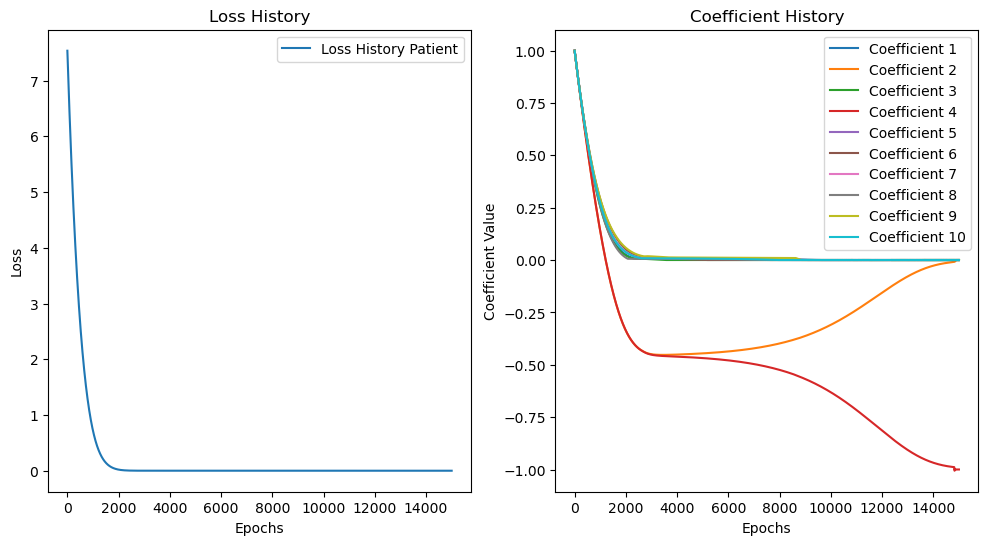

In [28]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss History Patient')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

# Plotting the coefficient history
plt.subplot(1, 2, 2)
coeff_array = np.array(coefficient_history)  # Assuming coefficient_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Coefficient Value')
plt.title('Coefficient History')
plt.legend()
plt.show()


In [29]:
# Print the final state of the mask
print("Final State of Mask Upsilon, Patient:")
print(trained_model.upsilon)
print("Final State of Mask Upsilon, Sequential:")
print(trained_model_seq.upsilon)


Final State of Mask Upsilon, Patient:
tensor([[False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])
Final State of Mask Upsilon, Sequential:
tensor([[False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False]])


$1.5\quad $Small Angle Approximation Train SINDy again using initial conditions $z_0$ and $\dot{z}_0$ with much smaller magnitude than in the
 original training set and determine at which point $-\sin(z)$ is not the only non-zero coefficient anymore. Explain why. Since the rejection of extreme scenarios is not needed for small initial conditions, your may simulate the data with rejection = False and accept all sampled initial conditions.

In [30]:
# Generate training data
N_samples = 100  # Number of different initial conditions to simulate
T=500
dt = 0.02
training_data = create_pendulum_data(-np.pi, np.pi, -10, 10, coeff, terms, T, dt, N_samples)

# Assuming create_pendulum_data returns a list of arrays where each array has shape (T, 3)
# Flatten the training data for SINDy
flat_data = np.concatenate(training_data, axis=0)


In [31]:
def create_theta_matrix_torch(z, dz):
    # Ensure this function creates a 2D matrix with a column for each term
    return torch.stack([
        torch.ones_like(z).flatten(),  # 1
        z.flatten(),                   # z
        dz.flatten(),                  # dz
        torch.sin(z).flatten(),        # sin(z)
        (z ** 2).flatten(),            # z^2
        (z * dz).flatten(),            # z*dz
        (z * torch.sin(z)).flatten(),  # z*sin(z)
        (dz ** 2).flatten(),           # dz^2
        (dz * torch.sin(z)).flatten(), # dz*sin(z)
        (torch.sin(z) ** 2).flatten()  # sin(z)^2
    ], dim=1)



In [32]:
class SINDy(nn.Module):
    def __init__(self, num_terms):
        super(SINDy, self).__init__()
        self.xi = nn.Parameter(torch.ones(num_terms, 1), requires_grad=True)

    def forward(self, theta):
        # Now the forward method only takes theta as the input
        return torch.matmul(theta, self.xi)

# Train the SINDy model
num_terms = 10  # Assuming you have 10 terms in your model
sindy_model = SINDy(num_terms)
learning_rate = 0.001
epochs = 10000
regularization_strength = 0.005  # Adjusted regularization strength

# Prepare the data for PyTorch by converting to tensors and including all three components (z, dz, ddz)
z = torch.tensor(flat_data[:, 0], dtype=torch.float32).view(-1, 1)
dz = torch.tensor(flat_data[:, 1], dtype=torch.float32).view(-1, 1)
ddz = torch.tensor(flat_data[:, 2], dtype=torch.float32).view(-1, 1)

# Combine z and dz into the Theta matrix for the SINDy model
theta = create_theta_matrix_torch(z, dz)
def train_sindy(model, theta, ddz, learning_rate, epochs, regularization_strength, thresholding=None, a=0.01, b=0.05, S=100, P=50):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    loss_history = []
    coefficient_history = []
    E_a, E_b = torch.zeros_like(model.xi), torch.zeros_like(model.xi)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(theta)
        loss = criterion(predictions, ddz)

        # Apply L1 regularization
        l1_regularization = regularization_strength * torch.norm(model.xi, 1)
        total_loss = loss + l1_regularization

        total_loss.backward()
        optimizer.step()

        # Apply thresholding
        if thresholding == "sequential" and epoch % S == 0:
            with torch.no_grad():
                model.upsilon[model.xi.abs() < a] = False
                model.xi.data[model.xi.abs() < a] = 0

        elif thresholding == "patient":
            with torch.no_grad():
                exceeded_a = model.xi.abs() > a
                exceeded_b = model.xi.abs() > b
                E_a[exceeded_a] = epoch
                E_b[exceeded_b] = epoch
                trend_mask = ((epoch - E_a) < P) | ((epoch - E_b) < P)
                model.upsilon = model.upsilon & trend_mask

        loss_history.append(total_loss.item())
        coefficient_history.append(model.xi.data.numpy().copy())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Total Loss = {total_loss.item()}")

    return model, loss_history, coefficient_history





In [33]:
theta

tensor([[ 1.0000, -2.5378, -2.5491,  ...,  6.4980,  1.4473,  0.3224],
        [ 1.0000, -0.5706, -0.5587,  ...,  0.3122,  0.3018,  0.2917],
        [ 1.0000,  0.5963,  0.5864,  ...,  0.3438,  0.3293,  0.3154],
        ...,
        [ 1.0000,  1.9151,  1.9015,  ...,  3.6158,  1.7899,  0.8860],
        [ 1.0000, -0.6707, -0.6889,  ...,  0.4746,  0.4282,  0.3863],
        [ 1.0000, -0.9078, -0.9114,  ...,  0.8306,  0.7183,  0.6211]])

In [34]:
# Train the SINDy model with the corrected function call
trained_model, loss_history, coefficient_history = train_sindy(
    sindy_model,
    theta,
    ddz,
    learning_rate,
    epochs,
    regularization_strength
)

# Extract the trained coefficients
trained_coefficients = trained_model.xi.data.numpy()

Epoch 0: Total Loss = 108.18889617919922
Epoch 100: Total Loss = 87.9712905883789
Epoch 200: Total Loss = 70.72770690917969
Epoch 300: Total Loss = 56.1732063293457
Epoch 400: Total Loss = 44.02538299560547
Epoch 500: Total Loss = 34.010337829589844
Epoch 600: Total Loss = 25.865110397338867
Epoch 700: Total Loss = 19.339252471923828
Epoch 800: Total Loss = 14.196513175964355
Epoch 900: Total Loss = 10.216628074645996
Epoch 1000: Total Loss = 7.197190284729004
Epoch 1100: Total Loss = 4.955428123474121
Epoch 1200: Total Loss = 3.3296048641204834
Epoch 1300: Total Loss = 2.179924964904785
Epoch 1400: Total Loss = 1.388702392578125
Epoch 1500: Total Loss = 0.8597192168235779
Epoch 1600: Total Loss = 0.5167782306671143
Epoch 1700: Total Loss = 0.3015724718570709
Epoch 1800: Total Loss = 0.17108209431171417
Epoch 1900: Total Loss = 0.09476430714130402
Epoch 2000: Total Loss = 0.05178866907954216
Epoch 2100: Total Loss = 0.02853027917444706
Epoch 2200: Total Loss = 0.01645534485578537
Epoch

In [35]:
# Generate new initial conditions for testing
test_initial_conditions = create_pendulum_data(-np.pi, np.pi, -10, 10, coeff, terms, T, dt, 5)

# Select one set of initial conditions for demonstration purposes
z0_test, dz0_test = test_initial_conditions[0][0, 0], test_initial_conditions[0][1, 0]

# Resimulate the pendulum using the trained coefficients and the test initial conditions
resimulated_data, t = simulate_pendulum(z0_test, dz0_test, trained_coefficients, terms, T, dt)

# Plot the resimulated data
plt.figure(figsize=(12, 6))
plt.plot(t, resimulated_data[:, 0], label='Resimulated z(t)')
plt.plot(t, resimulated_data[:, 1], label='Resimulated dz(t)/dt')
plt.title('Resimulated System Dynamics')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 4)

# Some tasks are doubled here since we couldnt merge the files correctly in time. This is ugly but it should still work

## 2.2 Hyperparameter Optimization

<div style="color: green; font-weight: bold">Our implementation of the AE is rather simplistic compared to the worked example. However our solution meets the requirements of 2.2. The only thing "wrong" here, is the optional ReLU layers. During implementation the requirements were misunderstood. However since the ReLU layers are only optional, this is not a big deal. Also we use the nn.Sequential to store our layers, so we don't have to loop over the layers in the methods forward, decode and encode.  </div>

In [229]:
class VariableAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, layers, activation="ReLU"):
        assert activation =="ReLU" or activation == "sigmoid"
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers

        self.activation = activation
        self.encoder = []
        self.decoder = []
        self.encoder.append(nn.Linear(self.input_size, self.hidden_size))
        if activation == "ReLU":
            self.encoder.append(nn.ReLU())
        self.decoder.append(nn.Linear(1, self.hidden_size))
        if activation == "ReLU":
            self.encoder.append(nn.ReLU())


        for layer in range(self.layers - 1):
            self.encoder.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.decoder.append(nn.Linear(self.hidden_size, self.hidden_size))

            if activation == "ReLU":
                self.encoder.append(nn.ReLU())
                self.decoder.append(nn.ReLU())

            if activation == "sigmoid":
                self.encoder.append(nn.Sigmoid())
                self.decoder.append(nn.Sigmoid())

        self.encoder.append(nn.Linear(self.hidden_size, 1))
        self.decoder.append(nn.Linear(self.hidden_size, self.input_size))

        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))




In [230]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = np.array(create_pendulum_data(-1, 1, -1, 1, coeff, terms, 1000, 0.02, 15, embedding = None, rejection = True))

def create_train_test_set(data, p_train, p_test):
    assert p_train >= 0 and p_test >= 0  and p_train + p_test == 1
    data = np.array([embed_cartesian(*simulation) for simulation in data])
    #np.random.shuffle(data)
    data = np.concatenate(data, axis=2).T
    data_train, data_test = train_test_split(data, test_size = p_test, train_size=p_train)
    return data_train, data_test
data_train, data_test = create_train_test_set(data, 0.4, 0.6)

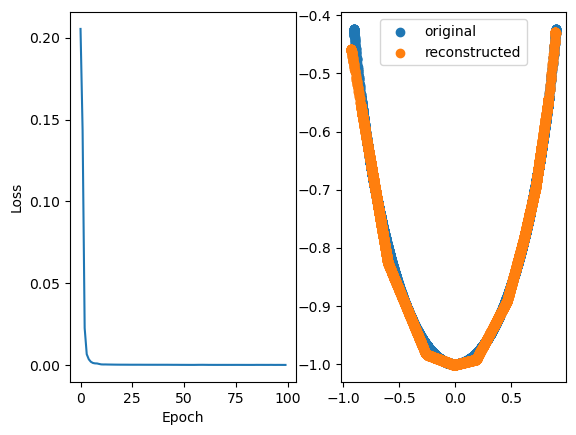

In [231]:
def calc_loss(model, data, criterion):
    outputs = model(data)
    loss = criterion(outputs, data)
    return loss

def train_auto_encoder(autoencoder, train_data, num_epochs, lr=0.001):
    X = torch.FloatTensor(train_data)#.reshape(-1, train_data.shape[0] * train_data.shape[2]).T)
    dataset = TensorDataset(X)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_list=[]
    for epoch in range(num_epochs):
        for data in data_loader:
            inputs = data[0]
            loss = calc_loss(model, inputs, criterion)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        loss_list.append(loss.item())

    return loss_list


model = VariableAutoencoder(2, 15, 5, "ReLU")
num_epoch = 100
loss_list = train_auto_encoder(model, data_train[:, :, 0], num_epoch)
reconstructed_test_data = model.forward(torch.FloatTensor(data_test[:, :, 0])).detach().numpy()#.reshape(-1, data_test.shape[0] * data_test.shape[2]).T)).detach().numpy()
# Plot loss
fig, axs = plt.subplots(1, 2)
axs[0].plot(range(num_epoch), loss_list, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].scatter(data_test[:, 0, 0], data_test[:, 1, 0], label="original")
axs[1].scatter(reconstructed_test_data[:, 0], reconstructed_test_data[:, 1], label="reconstructed")

plt.legend()
plt.show()


This shows the results of the auto encoder without embedded coordinates and derivatives. The reconstruction is quite good but no perfect. Also, by increasing the hidden layer size or the number of layers, the results will get worse, since the model learns the mean of all points and will only return this.

<div style="color: green; font-weight: bold">In essence both solutions for the training are the same. We both train the AE using MSELoss. However the provided solution has a lot more additional functionality, such as validation and hyperparameter tuning. We did the tuning manually, hence there are no measurements for this here, only two plots for the best parameters we could find. </div>

## 2.3 Propagation of Time Derivatives

<div style="color: green; font-weight: bold">Our implementation of the layers are quite similar to the ones in the worked example. The main difference is, that in the worked example, the input derivatives are allowed to be None. In our case we always assume, that a derivative is provided. Hence the provided solution is better.</div>

In [77]:
class LinearDerivatives(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer = nn.Linear(input_size, output_size)

    def forward(self, X):
        x, dx, ddx = X[:, :, 0], X[:, :, 1], X[:, :, 2]

        z = self.layer(x)
        dz = self.layer(dx) - self.layer.state_dict()['bias']
        ddz = self.layer(ddx) - self.layer.state_dict()['bias']
        return torch.stack([z.T, dz.T, ddz.T]).T


In [78]:
class SigmoidDerivatives(nn.Module):
    def __init__(self):
        super().__init__()

    def der2_sigmoid(self, x):
        return self.der_sigmoid(x) * (1 - 2*nn.functional.sigmoid(x))

    def der_sigmoid(self, x):
        return nn.functional.sigmoid(x) * (1 - nn.functional.sigmoid(x))

    def forward(self, Z):
        z_t, dz_t, ddz_t = Z[:, :, 0], Z[:, :, 1], Z[:, :, 2]
        z = nn.functional.sigmoid(z_t)
        dz = self.der_sigmoid(z_t) * dz_t
        ddz = (self.der2_sigmoid(z_t) * dz_t) * dz_t + (self.der_sigmoid(z_t) * ddz_t)
        return torch.stack([z.T, dz.T, ddz.T]).T


<div style="color: green; font-weight: bold">Again our implementation is not as sophisticated as the implementation in the worked example. The main problem here is that we didn't do the xavier initialization. This is a problem.</div>

In [79]:
class VariableAutoencoderWithDerivatives(nn.Module):
    def __init__(self, input_size, hidden_size, layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers

        self.encoder = []
        self.decoder = []
        self.encoder.append(LinearDerivatives(self.input_size, self.hidden_size))
        #self.encoder.append(SigmoidDerivatives())

        #self.decoder.append(SigmoidDerivatives())
        self.decoder.append(LinearDerivatives(1, self.hidden_size))
        #self.decoder.append(SigmoidDerivatives())


        for layer in range(self.layers - 1):
            self.encoder.append(LinearDerivatives(self.hidden_size, self.hidden_size))
            self.decoder.append(LinearDerivatives(self.hidden_size, self.hidden_size))

            self.encoder.append(SigmoidDerivatives())
            self.decoder.append(SigmoidDerivatives())

        self.encoder.append(LinearDerivatives(self.hidden_size, 1))
        self.decoder.append(LinearDerivatives(self.hidden_size, self.input_size))

        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)


    def encode(self, x):
        return self.encoder.forward(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))



(600, 2, 3)


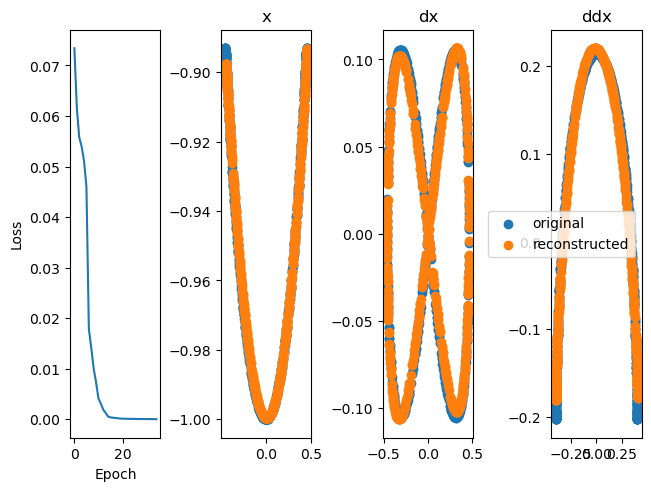

In [80]:
model = VariableAutoencoderWithDerivatives(2, 250, 3)
num_epoch = 35
loss_list = train_auto_encoder(model, data_train, num_epoch)



reconstructed_test_data = model.forward(torch.FloatTensor(data_test)).detach().numpy()#.reshape(-1, data_test.shape[0] * data_test.shape[2]).T)).detach().numpy()
# Plot loss
fig, axs = plt.subplots(1, 4, constrained_layout=True)
axs[0].plot(range(num_epoch), loss_list, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
print(data_test.shape)
axs[1].set_title("x")
axs[1].scatter(data_test[:, 0, 0], data_test[:, 1, 0], label="original")
axs[1].scatter(reconstructed_test_data[:, 0, 0], reconstructed_test_data[:, 1, 0], label="reconstructed")

axs[2].set_title("dx")
axs[2].scatter(data_test[:, 0, 1], data_test[:, 1, 1], label="original")
axs[2].scatter(reconstructed_test_data[:, 0, 1], reconstructed_test_data[:, 1, 1], label="reconstructed")


axs[3].set_title("ddx")
axs[3].scatter(data_test[:, 0, 2], data_test[:, 1, 2], label="original")
axs[3].scatter(reconstructed_test_data[:, 0, 2], reconstructed_test_data[:, 1, 2], label="reconstructed")

plt.legend()
plt.show()

This shows the results of the auto encoder with embedded coordinates and derivatives. The reconstruction is quite good but no perfect. Also, by increasing the hidden layer size or the number of layers, the results will get worse, since the model learns the mean of all points and will only return this.

<div style="color: green; font-weight: bold">We made some mistakes regarding the validation of the derivatives. We tried to validate the derivative provided by the AE. The plot above shows that the input derivatives can be reconstructed. However our validation of the derivatives in Z space is unusable. In the provided solution, they validate the correctness of a single layer. Hence some induction argument can be made. This is much more elegant and the results are usable. </div>

In [81]:
z_test = model.encoder(torch.FloatTensor(data_test)).detach().numpy()

In [82]:
def finite_differences_first_order(x, dt):
    x_dot = []
    for i in range(1, len(x) - 1):
        x_dot.append((x[i+1] - x[i-1]) / (2* dt))
    return x_dot

In [83]:
def finite_differences_second_order(x, dt):
    x_ddot = []
    for i in range(1, len(x) - 1):
        x_ddot.append((x[i-1]  -2*x[i] + x[i+1]) / (dt**2))
    return x_ddot

In [84]:
z_dot = finite_differences_first_order(z_test[:, :, 0], 0.6)

In [85]:
z_ddot = finite_differences_second_order(z_test[:, :, 0], 2)

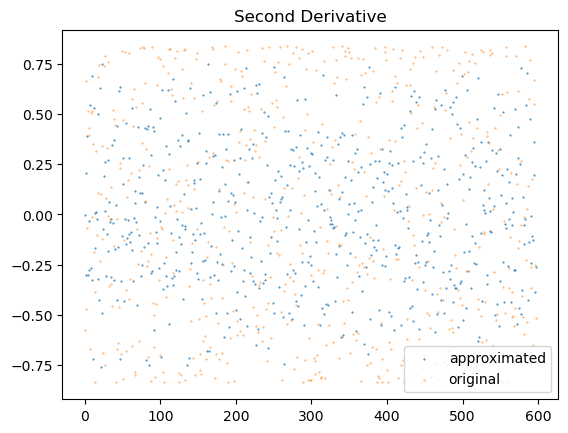

In [86]:
plt.title("Second Derivative")
plt.scatter(range(len(z_dot)), z_ddot, s=0.2, label="approximated")
plt.scatter(range(len(z_dot)), z_test[1:-1, :, 1], s=0.1, label="original")
plt.legend()

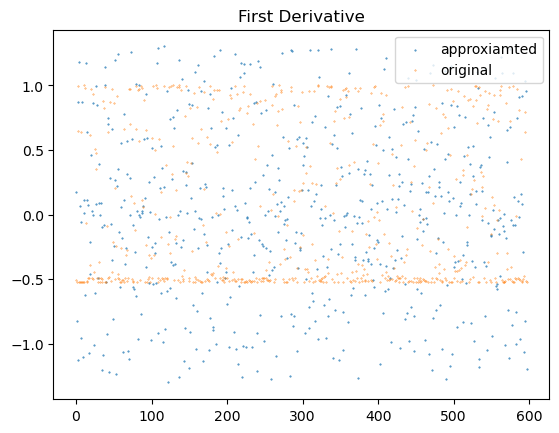

In [87]:
plt.title("First Derivative")
plt.scatter(range(len(z_dot)), z_dot, s=0.2, label="approxiamted")
plt.scatter(range(len(z_dot)), z_test[1:-1, :, 2], s=0.1, label="original")
plt.legend()

Since the step size $\Delta$t is not known in z-space, it is hard to approximate the derivatives. Also since both derivatives dont follow obvious patterns, it is also hard to compare the computed derivative with the derivatives from the auto encoder. Also using finite differences especially the second order approximation is generally bad.

## 2.4 Implementation

<div style="color: green; font-weight: bold">In the provided solution they implemented the SINDyAE right from the beginning. We only combine our previous AE with the SINDy class, hence the same flaws are present in this class too.</div>

In [150]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = np.array(create_pendulum_data(-1, 1, -1, 1, coeff, terms, 100, 0.02, 1, embedding = None, rejection = True))

data_train, data_test = create_train_test_set(data, 0.4, 0.6)

In [151]:
class SINDy(nn.Module):
    def __init__(self, num_terms):
        super(SINDy, self).__init__()
        self.xi = nn.Parameter(torch.ones(num_terms, 1), requires_grad=True)
        self.upsilon = torch.ones(num_terms, 1, dtype=torch.bool)

    def forward(self, z, dz):
        theta = create_theta_matrix_torch(z, dz)
        return torch.matmul(theta, self.xi * self.upsilon)[:, 0]

In [152]:
class SINDyAutoencoder(nn.Module):
  def __init__(self, input_size, hidden_size, layers, num_terms):
    super().__init__()
    self.SINDy = SINDy(num_terms)
    self.autoencoder = VariableAutoencoderWithDerivatives(input_size, hidden_size, layers)

  def forward(self,X):
    Z = self.autoencoder.encode(X)
    z = Z[:,:,0]
    dz = Z[:,:,1]
    ddz = Z[:,:,2]

    ddz_hat = self.SINDy.forward(z, dz)
    X_HAT = self.autoencoder.forward(X)
    x_hat = X_HAT[:,:,0]


    Z_HAT = torch.stack([z.T, dz.T, ddz_hat.reshape(dz.shape).T]).T
    ddx_hat = self.autoencoder.decode(Z_HAT)[:,:,2]
    return (x_hat, ddx_hat, ddz, ddz_hat)






In [153]:
def train_sindy_autoencoder(model, data, num_epochs, l_1, l_ddx, l_ddz, refinement_epoch = 10, lr=0.001, thresholding = "patient",  a=0.01, b=0.05, S=100, P=50):
    X = torch.FloatTensor(data)
    dataset = TensorDataset(X)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    coefficient_history = []
    upsilon_history = []
    E_a, E_b = torch.zeros_like(model.SINDy.xi), torch.zeros_like(model.SINDy.xi)


    loss_list=[]
    for epoch in range(num_epochs):
        for data in data_loader:
            inputs = data[0]
            if epoch == refinement_epoch:
              l_1 = 0
            x, dx, ddx = inputs[:, :, 0], inputs[:, :, 1], inputs[:, :, 2]
            x_hat, ddx_hat, ddz, ddz_hat = model.forward(inputs)
            x_hat_loss = criterion(x, x_hat)
            ddz_hat_loss =  criterion(ddz[:, 0], ddz_hat)
            ddx_hat_loss =  criterion(ddx, ddx_hat)
            l1_loss = torch.norm(model.SINDy.xi, 1)
            loss = torch.mean(x_hat_loss + l_ddz * ddz_hat_loss
            + l_ddx * ddx_hat_loss) + l_1 * l1_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        loss_list.append(loss.item())

         # Apply thresholding
        if thresholding == "sequential" and epoch % S == 0:
            with torch.no_grad():
                model.SINDy.upsilon[model.SINDy.xi.abs() < a] = False
                model.SINDy.xi.data[model.SINDy.xi.abs() < a] = 0

        elif thresholding == "patient":
            with torch.no_grad():
                exceeded_a = model.SINDy.xi.abs() > a
                exceeded_b = model.SINDy.xi.abs() > b
                E_a[exceeded_a] = epoch
                E_b[exceeded_b] = epoch
                trend_mask = ((epoch - E_a) < P) | ((epoch - E_b) < P)
                model.SINDy.upsilon = model.SINDy.upsilon & trend_mask


        coefficient_history.append(model.SINDy.xi.data.numpy().copy())
        upsilon_history.append(model.SINDy.upsilon.data.numpy().copy())


        if epoch % 100 == 0:
          print(f"Epoch {epoch}: Total Loss = {loss.item()}, X-Loss: {x_hat_loss}, DDZ-Loss: {ddz_hat_loss}, DDX-Loss: {ddx_hat_loss}, L1-Loss: {l1_loss}")

    return loss_list, coefficient_history, upsilon_history



In [159]:
sindy = SINDyAutoencoder(2,150,3, 10)

In [160]:
loss_history,  coefficient_history, upsilon_history = train_sindy_autoencoder(sindy, data_train, 6000, 1E-5, 5E-4, 5E-5, refinement_epoch = 5000, thresholding = "patient", P=1000, b= 0.002, a = 0.1, S = 500, )

Epoch 0: Total Loss = 0.15675607323646545, X-Loss: 0.1564175933599472, DDZ-Loss: 0.9004071950912476, DDX-Loss: 0.38692715764045715, L1-Loss: 10.0
Epoch 100: Total Loss = 0.018167342990636826, X-Loss: 0.017883004620671272, DDZ-Loss: 0.8915815353393555, DDX-Loss: 0.29151612520217896, L1-Loss: 9.400198936462402
Epoch 200: Total Loss = 0.00046761089470237494, X-Loss: 0.00021968837245367467, DDZ-Loss: 1.652379035949707, DDX-Loss: 0.15357109904289246, L1-Loss: 8.851802825927734
Epoch 300: Total Loss = 0.0003450659569352865, X-Loss: 0.00016368180513381958, DDZ-Loss: 0.7769435048103333, DDX-Loss: 0.11188499629497528, L1-Loss: 8.659444808959961
Epoch 400: Total Loss = 0.0002850430319085717, X-Loss: 0.00012881883594673127, DDZ-Loss: 0.5434341430664062, DDX-Loss: 0.0889541357755661, L1-Loss: 8.457542419433594
Epoch 500: Total Loss = 0.00022100729984231293, X-Loss: 8.132054790621623e-05, DDZ-Loss: 0.4909612238407135, DDX-Loss: 0.0658775120973587, L1-Loss: 8.219992637634277
Epoch 600: Total Loss = 

Epoch 4900: Total Loss = 9.678611604613252e-06, X-Loss: 5.533840408133983e-07, DDZ-Loss: 0.010845335200428963, DDX-Loss: 0.00031627455609850585, L1-Loss: 0.842482328414917
Epoch 5000: Total Loss = 9.783681207409245e-07, X-Loss: 3.3590308134989755e-07, DDZ-Loss: 0.009516574442386627, DDX-Loss: 0.00033327279379591346, L1-Loss: 0.8214000463485718
Epoch 5100: Total Loss = 7.190912469923205e-07, X-Loss: 2.491849784291844e-07, DDZ-Loss: 0.0072664134204387665, DDX-Loss: 0.00021317119535524398, L1-Loss: 0.8536071181297302
Epoch 5200: Total Loss = 5.4434494813904166e-05, X-Loss: 5.354405220714398e-05, DDZ-Loss: 0.012396970763802528, DDX-Loss: 0.0005411892780102789, L1-Loss: 0.8899123668670654
Epoch 5300: Total Loss = 7.501731147385726e-07, X-Loss: 2.1093910618219525e-07, DDZ-Loss: 0.008725100196897984, DDX-Loss: 0.00020595805835910141, L1-Loss: 0.9042255282402039
Epoch 5400: Total Loss = 6.382882702382631e-07, X-Loss: 1.6273372693831334e-07, DDZ-Loss: 0.007586780935525894, DDX-Loss: 0.000192431

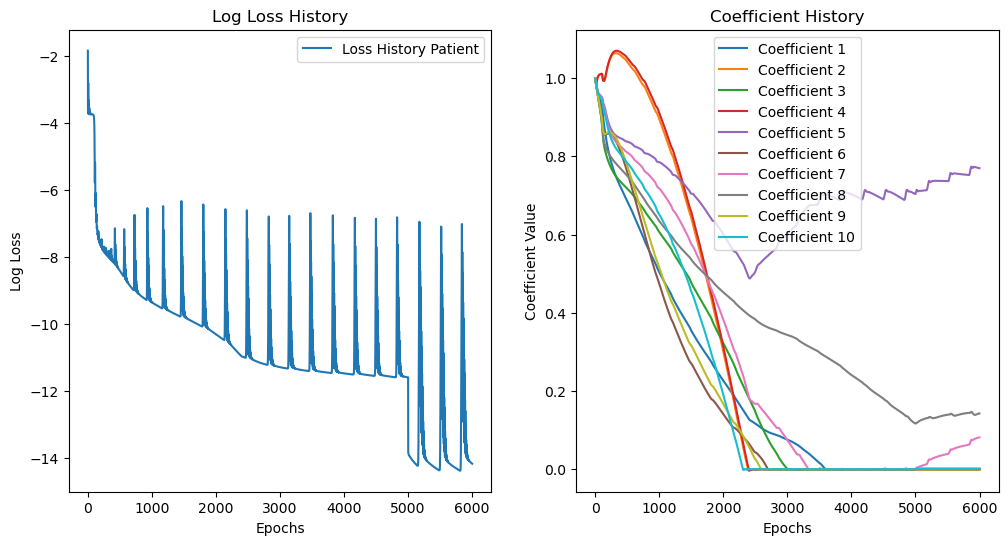

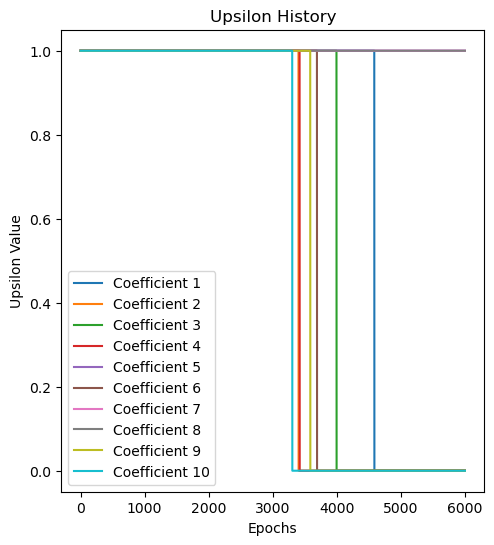

In [161]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.log(loss_history), label='Loss History Patient')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Log Loss History')
plt.legend()

# Plotting the coefficient history
plt.subplot(1, 2, 2)
coeff_array = np.array(coefficient_history)  # Assuming coefficient_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Coefficient Value')
plt.title('Coefficient History')
plt.legend()
plt.show()

# Plotting the coefficient history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
coeff_array = np.array(upsilon_history)  # Assuming upsilon_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Upsilon Value')
plt.title('Upsilon History')
plt.legend()
plt.show()


<div style="color: green; font-weight: bold">All tho our implementations are less sophisticated than the provided ones, the resulting plots of coefficient history and error are quite similar. The errors go down over time with some ripple to them. During refinement, the error drops drastically and in the end a lot of coefficients are present but not sin(z). However we are missing the resimulation.</div>

The plot above shows the history of the log loss, coefficients and upsilons for the sindy auto encoder with PTAT. The most noticeable thing is, that the error decreases a lot during refinement. Also during that period, the remaining coefficients change a lot. There is quite a lot of rippeling on the log loss. In this run, the results are not desireball since neiter sin(z) nor z was identified but rather some product of both.

In [162]:
sindy2 = SINDyAutoencoder(2,150,3, 10)
loss_history,  coefficient_history, upsilon_history = train_sindy_autoencoder(sindy2, data_train, 6000, 1E-5, 5E-4, 5E-5, refinement_epoch = 5000, thresholding = "seqiential", P=1000, b= 0.002, a = 0.1, S = 500, )

Epoch 0: Total Loss = 0.5568599104881287, X-Loss: 0.5565155744552612, DDZ-Loss: 1.1543753147125244, DDX-Loss: 0.3732292950153351, L1-Loss: 10.0
Epoch 100: Total Loss = 0.01979666016995907, X-Loss: 0.019520554691553116, DDZ-Loss: 0.4422222673892975, DDX-Loss: 0.31736043095588684, L1-Loss: 9.53127384185791
Epoch 200: Total Loss = 0.000537336862180382, X-Loss: 0.00023615514510311186, DDZ-Loss: 2.193085193634033, DDX-Loss: 0.2019236981868744, L1-Loss: 9.056564331054688
Epoch 300: Total Loss = 0.0004096230841241777, X-Loss: 0.00019685897859744728, DDZ-Loss: 0.9369915127754211, DDX-Loss: 0.15414559841156006, L1-Loss: 8.884174346923828
Epoch 400: Total Loss = 0.0003638832422439009, X-Loss: 0.00018018191622104496, DDZ-Loss: 0.582273542881012, DDX-Loss: 0.13504202663898468, L1-Loss: 8.7066650390625
Epoch 500: Total Loss = 0.0003245584957767278, X-Loss: 0.00016025076911319047, DDZ-Loss: 0.37257134914398193, DDX-Loss: 0.12111756950616837, L1-Loss: 8.512038230895996
Epoch 600: Total Loss = 0.00031

Epoch 4900: Total Loss = 8.810145118332002e-06, X-Loss: 2.0328691618942685e-07, DDZ-Loss: 0.005946671590209007, DDX-Loss: 0.0003099250025115907, L1-Loss: 0.8154562711715698
Epoch 5000: Total Loss = 6.2009635257709306e-06, X-Loss: 5.44789872947149e-06, DDZ-Loss: 0.010502053424715996, DDX-Loss: 0.0004559243971016258, L1-Loss: 0.8116428256034851
Epoch 5100: Total Loss = 5.771709652435675e-07, X-Loss: 1.875594932698732e-07, DDZ-Loss: 0.0056752427481114864, DDX-Loss: 0.00021169870160520077, L1-Loss: 0.8636626601219177
Epoch 5200: Total Loss = 3.997246267317678e-07, X-Loss: 1.1473375849391232e-07, DDZ-Loss: 0.003985031042248011, DDX-Loss: 0.0001714786485536024, L1-Loss: 0.8877498507499695
Epoch 5300: Total Loss = 0.00012685052934102714, X-Loss: 0.0001259298005606979, DDZ-Loss: 0.00802593119442463, DDX-Loss: 0.0010388661175966263, L1-Loss: 0.9115204811096191
Epoch 5400: Total Loss = 4.937290896123159e-07, X-Loss: 1.4271708437263442e-07, DDZ-Loss: 0.005223600193858147, DDX-Loss: 0.000179663969

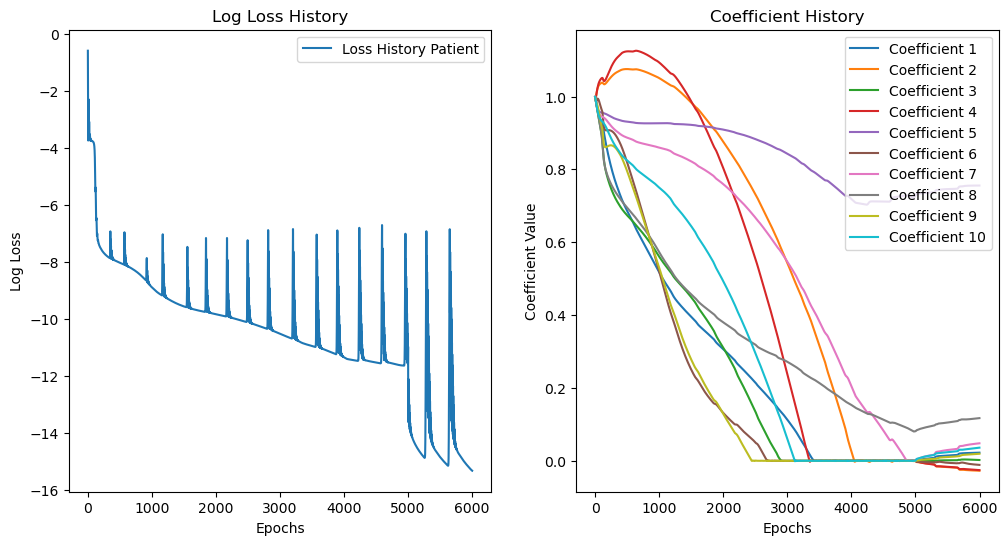

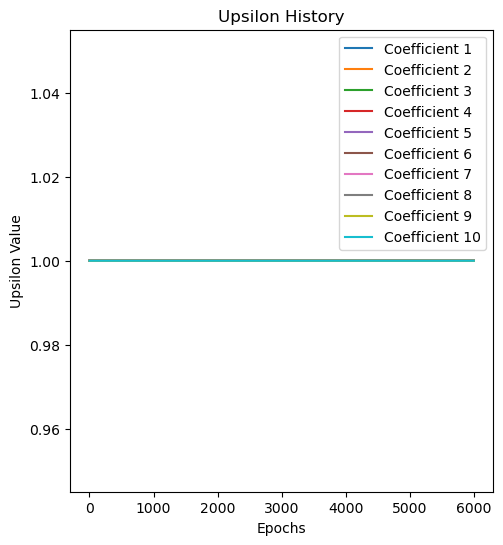

In [163]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.log(loss_history), label='Loss History Patient')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Log Loss History')
plt.legend()

# Plotting the coefficient history
plt.subplot(1, 2, 2)
coeff_array = np.array(coefficient_history)  # Assuming coefficient_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Coefficient Value')
plt.title('Coefficient History')
plt.legend()
plt.show()

# Plotting the coefficient history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
coeff_array = np.array(upsilon_history)  # Assuming upsilon_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Upsilon Value')
plt.title('Upsilon History')
plt.legend()
plt.show()

The plot above shows the history of the log loss, coefficients and upsilons for the sindy auto encoder with sequential thresholding. The most noticeable thing is, that the error decreases a lot during refinement. Also during that period, the  coefficients change a lot. There is quite a lot of rippeling on the log loss. In this run, the results are not desireball since neiter sin(z) nor z was identified but rather some product of both. Also the thresholding is not working since no coefficient gets muted.

<div style="color: green; font-weight: bold">For sequential thresholding, our solution differs quite a lot. Here no coefficient gets muted over time. Hence, there is some mistake in implementation or some parameter is bad. The worked example provides better results. Again, the FVU and resimulation is missing here.</div>

In [165]:
patient_final_xis = []
patient_final_ups = []

seq_final_xis = []
seq_final_ups = []

for i in range(10):
    sindy = SINDyAutoencoder(2,150,3, 10)
    train_sindy_autoencoder(sindy, data_train, 6000, 1E-5, 5E-4, 5E-5, refinement_epoch = 5000, thresholding = "patient", P=1000, b= 0.002, a = 0.1, S = 500, )
    sindy2 = SINDyAutoencoder(2,150,3, 10)
    train_sindy_autoencoder(sindy2, data_train, 6000, 1E-5, 5E-4, 5E-5, refinement_epoch = 5000, thresholding = "seqiential", P=1000, b= 0.002, a = 0.1, S = 500, )
    patient_final_xis.append(sindy.SINDy.xi)
    patient_final_ups.append(sindy.SINDy.upsilon)
    seq_final_xis.append(sindy2.SINDy.xi)
    seq_final_ups.append(sindy2.SINDy.upsilon)

Epoch 0: Total Loss = 0.6433781385421753, X-Loss: 0.643021285533905, DDZ-Loss: 1.3354899883270264, DDX-Loss: 0.38017743825912476, L1-Loss: 10.0
Epoch 100: Total Loss = 0.02311994694173336, X-Loss: 0.022824406623840332, DDZ-Loss: 0.3496416509151459, DDX-Loss: 0.3666977286338806, L1-Loss: 9.470788955688477
Epoch 200: Total Loss = 0.0005152201629243791, X-Loss: 0.00021003818255849183, DDZ-Loss: 2.0316333770751953, DDX-Loss: 0.23223471641540527, L1-Loss: 8.748294830322266
Epoch 300: Total Loss = 0.000385301245842129, X-Loss: 0.0001873927394626662, DDZ-Loss: 0.7746496200561523, DDX-Loss: 0.1469825804233551, L1-Loss: 8.568474769592285
Epoch 400: Total Loss = 0.00030698877526447177, X-Loss: 0.00014485756400972605, DDZ-Loss: 0.4179861545562744, DDX-Loss: 0.1142602413892746, L1-Loss: 8.410177230834961
Epoch 500: Total Loss = 0.0002739056362770498, X-Loss: 0.0001264992170035839, DDZ-Loss: 0.336941123008728, DDX-Loss: 0.09611999243497849, L1-Loss: 8.2499361038208
Epoch 600: Total Loss = 0.0002356

Epoch 4900: Total Loss = 1.3620550816995092e-05, X-Loss: 3.507092060317518e-06, DDZ-Loss: 0.013311830349266529, DDX-Loss: 0.0004592393524944782, L1-Loss: 0.9218248128890991
Epoch 5000: Total Loss = 8.500574040226638e-07, X-Loss: 2.1859287357983703e-07, DDZ-Loss: 0.009167058393359184, DDX-Loss: 0.00034622327075339854, L1-Loss: 0.9074035286903381
Epoch 5100: Total Loss = 5.771495921180758e-07, X-Loss: 1.326892657971257e-07, DDZ-Loss: 0.006623859051615, DDX-Loss: 0.00022653481573797762, L1-Loss: 0.9341006875038147
Epoch 5200: Total Loss = 0.0008388910791836679, X-Loss: 0.0008378842030651867, DDZ-Loss: 0.011710943654179573, DDX-Loss: 0.0008426567655988038, L1-Loss: 0.9467570185661316
Epoch 5300: Total Loss = 6.773043423891068e-07, X-Loss: 1.4325659947189706e-07, DDZ-Loss: 0.008270244114100933, DDX-Loss: 0.0002410711458651349, L1-Loss: 0.9774680733680725
Epoch 5400: Total Loss = 5.07435970575898e-07, X-Loss: 8.963571929143654e-08, DDZ-Loss: 0.0062977648340165615, DDX-Loss: 0.000205823991564

Epoch 3800: Total Loss = 1.3820475942338817e-05, X-Loss: 3.5370106843402027e-07, DDZ-Loss: 0.005221830680966377, DDX-Loss: 0.000608307309448719, L1-Loss: 1.2901530265808105
Epoch 3900: Total Loss = 1.3414070053840987e-05, X-Loss: 3.1334519690062734e-07, DDZ-Loss: 0.004867287818342447, DDX-Loss: 0.0005503870779648423, L1-Loss: 1.2582167387008667
Epoch 4000: Total Loss = 0.00011217331484658644, X-Loss: 9.924943879013881e-05, DDZ-Loss: 0.005860467441380024, DDX-Loss: 0.0007657855749130249, L1-Loss: 1.224795937538147
Epoch 4100: Total Loss = 1.3143213436705992e-05, X-Loss: 3.724200325905258e-07, DDZ-Loss: 0.006351301912218332, DDX-Loss: 0.0005040991818532348, L1-Loss: 1.2201179265975952
Epoch 4200: Total Loss = 1.267861807718873e-05, X-Loss: 3.098915328791918e-07, DDZ-Loss: 0.005819614045321941, DDX-Loss: 0.00047679562703706324, L1-Loss: 1.1839348077774048
Epoch 4300: Total Loss = 1.225471351062879e-05, X-Loss: 2.9084873176543624e-07, DDZ-Loss: 0.005518041085451841, DDX-Loss: 0.00046159917

Epoch 2700: Total Loss = 1.7842157831182703e-05, X-Loss: 2.175395081849274e-07, DDZ-Loss: 0.01828584261238575, DDX-Loss: 0.0029765579383820295, L1-Loss: 1.522204875946045
Epoch 2800: Total Loss = 1.629078178666532e-05, X-Loss: 1.9126257200241525e-07, DDZ-Loss: 0.015237684361636639, DDX-Loss: 0.002378952456638217, L1-Loss: 1.414815902709961
Epoch 2900: Total Loss = 1.5040856851555873e-05, X-Loss: 1.9396443917685247e-07, DDZ-Loss: 0.012231618165969849, DDX-Loss: 0.00193162786308676, L1-Loss: 1.3269498348236084
Epoch 3000: Total Loss = 1.4929230019333772e-05, X-Loss: 9.891751915347413e-07, DDZ-Loss: 0.010706779547035694, DDX-Loss: 0.0020620834548026323, L1-Loss: 1.2373673915863037
Epoch 3100: Total Loss = 1.3207935808168259e-05, X-Loss: 2.0666064415308938e-07, DDZ-Loss: 0.008315229788422585, DDX-Loss: 0.0014050205936655402, L1-Loss: 1.188300371170044
Epoch 3200: Total Loss = 1.274680471397005e-05, X-Loss: 1.9064272294144757e-07, DDZ-Loss: 0.006732189562171698, DDX-Loss: 0.0011442458489909

Epoch 1500: Total Loss = 7.807720976416022e-05, X-Loss: 5.380064067139756e-06, DDZ-Loss: 0.09249788522720337, DDX-Loss: 0.010530943050980568, L1-Loss: 6.280677795410156
Epoch 1600: Total Loss = 6.726448191329837e-05, X-Loss: 4.221280960337026e-07, DDZ-Loss: 0.06627801060676575, DDX-Loss: 0.006943903863430023, L1-Loss: 6.005650043487549
Epoch 1700: Total Loss = 6.281788228079677e-05, X-Loss: 3.894075177868217e-07, DDZ-Loss: 0.05181440711021423, DDX-Loss: 0.005150416400283575, L1-Loss: 5.726254940032959
Epoch 1800: Total Loss = 8.424624684266746e-05, X-Loss: 2.4000164557946846e-05, DDZ-Loss: 0.05621534585952759, DDX-Loss: 0.006060766521841288, L1-Loss: 5.440493106842041
Epoch 1900: Total Loss = 5.579513162956573e-05, X-Loss: 2.5727973707034835e-07, DDZ-Loss: 0.041977521032094955, DDX-Loss: 0.0039112986996769905, L1-Loss: 5.148332595825195
Epoch 2000: Total Loss = 5.212217365624383e-05, X-Loss: 2.9801896062053856e-07, DDZ-Loss: 0.033875033259391785, DDX-Loss: 0.00323849031701684, L1-Loss:

Epoch 300: Total Loss = 0.0003477184218354523, X-Loss: 0.00014967418974265456, DDZ-Loss: 0.8821378946304321, DDX-Loss: 0.13469627499580383, L1-Loss: 8.658921241760254
Epoch 400: Total Loss = 0.00026497471844777465, X-Loss: 0.00010977104830089957, DDZ-Loss: 0.4931250512599945, DDX-Loss: 0.09151609241962433, L1-Loss: 8.478938102722168
Epoch 500: Total Loss = 0.00019957206677645445, X-Loss: 6.592794670723379e-05, DDZ-Loss: 0.4137025773525238, DDX-Loss: 0.06030214950442314, L1-Loss: 8.280791282653809
Epoch 600: Total Loss = 0.00016800090088509023, X-Loss: 5.106178650748916e-05, DDZ-Loss: 0.3656749725341797, DDX-Loss: 0.03618493676185608, L1-Loss: 8.056288719177246
Epoch 700: Total Loss = 0.00011531126074260101, X-Loss: 9.364787729282398e-06, DDZ-Loss: 0.3230805993080139, DDX-Loss: 0.023533716797828674, L1-Loss: 7.802558898925781
Epoch 800: Total Loss = 0.0002967409964185208, X-Loss: 0.00019899560720659792, DDZ-Loss: 0.2553583085536957, DDX-Loss: 0.018915867432951927, L1-Loss: 7.55195617675

Epoch 5100: Total Loss = 6.847685085631383e-07, X-Loss: 2.394777141034865e-07, DDZ-Loss: 0.006689842790365219, DDX-Loss: 0.00022159730724524707, L1-Loss: 1.0075820684432983
Epoch 5200: Total Loss = 5.575483896791411e-07, X-Loss: 1.7231471360901196e-07, DDZ-Loss: 0.005877780262380838, DDX-Loss: 0.00018268934218212962, L1-Loss: 1.0229898691177368
Epoch 5300: Total Loss = 8.632200660940725e-07, X-Loss: 5.233736146692536e-07, DDZ-Loss: 0.005247100256383419, DDX-Loss: 0.00015498287393711507, L1-Loss: 1.048172116279602
Epoch 5400: Total Loss = 6.374434633471537e-07, X-Loss: 2.802295284709544e-07, DDZ-Loss: 0.005643164273351431, DDX-Loss: 0.00015011141658760607, L1-Loss: 1.0686523914337158
Epoch 5500: Total Loss = 0.00014396356709767133, X-Loss: 0.00014334722072817385, DDZ-Loss: 0.007121482398360968, DDX-Loss: 0.000520557165145874, L1-Loss: 1.0792696475982666
Epoch 5600: Total Loss = 4.7653395540692145e-07, X-Loss: 1.0847816156456247e-07, DDZ-Loss: 0.005965778604149818, DDX-Loss: 0.0001395337

Epoch 4000: Total Loss = 1.2146089829911944e-05, X-Loss: 1.8885245367528114e-07, DDZ-Loss: 0.007632554974406958, DDX-Loss: 0.0004055301542393863, L1-Loss: 1.137284517288208
Epoch 4100: Total Loss = 1.3758386558038183e-05, X-Loss: 1.8482453469914617e-06, DDZ-Loss: 0.01129145547747612, DDX-Loss: 0.00042915227822959423, L1-Loss: 1.1130993366241455
Epoch 4200: Total Loss = 1.1511341654113494e-05, X-Loss: 2.0947349810285232e-07, DDZ-Loss: 0.009160366840660572, DDX-Loss: 0.00038004055386409163, L1-Loss: 1.065382957458496
Epoch 4300: Total Loss = 1.1050277862523217e-05, X-Loss: 1.9757904112793767e-07, DDZ-Loss: 0.008215522393584251, DDX-Loss: 0.000354596326360479, L1-Loss: 1.026462435722351
Epoch 4400: Total Loss = 1.1203805115655996e-05, X-Loss: 2.599422828097886e-07, DDZ-Loss: 0.011517563834786415, DDX-Loss: 0.000351605995092541, L1-Loss: 1.0192182064056396
Epoch 4500: Total Loss = 1.0725930223998148e-05, X-Loss: 2.0216918983351206e-07, DDZ-Loss: 0.009627848863601685, DDX-Loss: 0.0003269341

Epoch 2900: Total Loss = 8.653895929455757e-05, X-Loss: 6.660392682533711e-05, DDZ-Loss: 0.015449127182364464, DDX-Loss: 0.002601875690743327, L1-Loss: 1.7861629724502563
Epoch 3000: Total Loss = 1.841200173657853e-05, X-Loss: 4.286513046736218e-07, DDZ-Loss: 0.01082339882850647, DDX-Loss: 0.0014698379673063755, L1-Loss: 1.6707261800765991
Epoch 3100: Total Loss = 1.6991076336125843e-05, X-Loss: 3.9078562963368313e-07, DDZ-Loss: 0.009872025810182095, DDX-Loss: 0.0012827232712879777, L1-Loss: 1.5465328693389893
Epoch 3200: Total Loss = 1.9698578398674726e-05, X-Loss: 4.421649919095216e-06, DDZ-Loss: 0.009118441492319107, DDX-Loss: 0.001168438815511763, L1-Loss: 1.4236788749694824
Epoch 3300: Total Loss = 1.4891091268509626e-05, X-Loss: 5.576124522121972e-07, DDZ-Loss: 0.00844083447009325, DDX-Loss: 0.0010571181774139404, L1-Loss: 1.3382878303527832
Epoch 3400: Total Loss = 1.363356932415627e-05, X-Loss: 4.5628158318322676e-07, DDZ-Loss: 0.007941787131130695, DDX-Loss: 0.0008725448278710

Epoch 1800: Total Loss = 0.0005688530509360135, X-Loss: 0.0004979013465344906, DDZ-Loss: 0.05126694589853287, DDX-Loss: 0.005567570216953754, L1-Loss: 6.560457706451416
Epoch 1900: Total Loss = 6.879051943542436e-05, X-Loss: 3.4689952599364915e-07, DDZ-Loss: 0.05435731261968613, DDX-Loss: 0.004196306224912405, L1-Loss: 6.362760543823242
Epoch 2000: Total Loss = 6.601984932785854e-05, X-Loss: 3.8339425145750283e-07, DDZ-Loss: 0.04280731827020645, DDX-Loss: 0.0034983549267053604, L1-Loss: 6.174691677093506
Epoch 2100: Total Loss = 0.00031555540044791996, X-Loss: 0.00025208800798282027, DDZ-Loss: 0.04108813405036926, DDX-Loss: 0.003469276474788785, L1-Loss: 5.967833042144775
Epoch 2200: Total Loss = 6.110991671448573e-05, X-Loss: 2.0619481233552506e-07, DDZ-Loss: 0.04160679131746292, DDX-Loss: 0.0028197718784213066, L1-Loss: 5.741349697113037
Epoch 2300: Total Loss = 5.8460496802581474e-05, X-Loss: 2.450162241984799e-07, DDZ-Loss: 0.032602228224277496, DDX-Loss: 0.002355748787522316, L1-L

Epoch 700: Total Loss = 0.00015755704953335226, X-Loss: 4.745466139866039e-05, DDZ-Loss: 0.3263161778450012, DDX-Loss: 0.03108367696404457, L1-Loss: 7.824474811553955
Epoch 800: Total Loss = 0.00010033530270447955, X-Loss: 4.129210537939798e-06, DDZ-Loss: 0.19945576786994934, DDX-Loss: 0.021701913326978683, L1-Loss: 7.538234710693359
Epoch 900: Total Loss = 9.769796452019364e-05, X-Loss: 7.747509698674548e-06, DDZ-Loss: 0.1729862242937088, DDX-Loss: 0.017896780744194984, L1-Loss: 7.235275745391846
Epoch 1000: Total Loss = 8.200953743653372e-05, X-Loss: 1.746818838910258e-06, DDZ-Loss: 0.10080472379922867, DDX-Loss: 0.011797318235039711, L1-Loss: 6.932382583618164
Epoch 1100: Total Loss = 0.00016348663484677672, X-Loss: 9.00864542927593e-05, DDZ-Loss: 0.06054407358169556, DDX-Loss: 0.008457191288471222, L1-Loss: 6.614437103271484
Epoch 1200: Total Loss = 7.010780245764181e-05, X-Loss: 1.001124587673985e-06, DDZ-Loss: 0.06032368540763855, DDX-Loss: 0.006332348100841045, L1-Loss: 6.292432

Epoch 5500: Total Loss = 3.816278422164032e-07, X-Loss: 1.062426591147414e-07, DDZ-Loss: 0.004157846327871084, DDX-Loss: 0.00013498574844561517, L1-Loss: 1.1240622997283936
Epoch 5600: Total Loss = 3.2487801604474953e-07, X-Loss: 8.378294324984381e-08, DDZ-Loss: 0.003688731463626027, DDX-Loss: 0.00011331702989991754, L1-Loss: 1.1304844617843628
Epoch 5700: Total Loss = 2.560455868660938e-06, X-Loss: 2.21521190724161e-06, DDZ-Loss: 0.005012966692447662, DDX-Loss: 0.00018919145804829895, L1-Loss: 1.1789989471435547
Epoch 5800: Total Loss = 3.46721947153128e-07, X-Loss: 8.113657656849682e-08, DDZ-Loss: 0.004235800355672836, DDX-Loss: 0.00010759071301436052, L1-Loss: 1.1819926500320435
Epoch 5900: Total Loss = 2.894566932809539e-07, X-Loss: 6.233182148207561e-08, DDZ-Loss: 0.0036644921638071537, DDX-Loss: 8.780058851698413e-05, L1-Loss: 1.186330795288086
Epoch 0: Total Loss = 0.3100600838661194, X-Loss: 0.30967819690704346, DDZ-Loss: 1.888930082321167, DDX-Loss: 0.37489378452301025, L1-Los

Epoch 4400: Total Loss = 1.2121588952140883e-05, X-Loss: 3.316093000194087e-07, DDZ-Loss: 0.005725591443479061, DDX-Loss: 0.000408852007240057, L1-Loss: 1.129927396774292
Epoch 4500: Total Loss = 6.731251778546721e-05, X-Loss: 5.590082218986936e-05, DDZ-Loss: 0.005040401592850685, DDX-Loss: 0.0003605152596719563, L1-Loss: 1.0979418754577637
Epoch 4600: Total Loss = 1.1946718586841598e-05, X-Loss: 4.3343598576939257e-07, DDZ-Loss: 0.007473851554095745, DDX-Loss: 0.0003960380854550749, L1-Loss: 1.094157099723816
Epoch 4700: Total Loss = 1.1505956535984296e-05, X-Loss: 3.389955622878915e-07, DDZ-Loss: 0.007180555257946253, DDX-Loss: 0.0004068574926350266, L1-Loss: 1.0604504346847534
Epoch 4800: Total Loss = 1.1145169082737993e-05, X-Loss: 3.1748365358907904e-07, DDZ-Loss: 0.006605587899684906, DDX-Loss: 0.0003825690073426813, L1-Loss: 1.0306121110916138
Epoch 4900: Total Loss = 1.1589805581024848e-05, X-Loss: 5.980584205644845e-07, DDZ-Loss: 0.009198987856507301, DDX-Loss: 0.0003977340238

Epoch 3300: Total Loss = 3.331556581542827e-05, X-Loss: 6.558974519066396e-07, DDZ-Loss: 0.008967151865363121, DDX-Loss: 0.003021272597834468, L1-Loss: 3.0700676441192627
Epoch 3400: Total Loss = 3.055443085031584e-05, X-Loss: 3.4813120919352514e-07, DDZ-Loss: 0.0056771948002278805, DDX-Loss: 0.0025378065183758736, L1-Loss: 2.86535382270813
Epoch 3500: Total Loss = 6.491973181255162e-05, X-Loss: 3.6754914617631584e-05, DDZ-Loss: 0.004776837769895792, DDX-Loss: 0.0021936874836683273, L1-Loss: 2.6829137802124023
Epoch 3600: Total Loss = 2.7459822376840748e-05, X-Loss: 2.722446481584484e-07, DDZ-Loss: 0.006831067614257336, DDX-Loss: 0.0018985879141837358, L1-Loss: 2.5896730422973633
Epoch 3700: Total Loss = 2.5694344003568403e-05, X-Loss: 2.498233584447007e-07, DDZ-Loss: 0.004068722017109394, DDX-Loss: 0.0015282242093235254, L1-Loss: 2.447697401046753
Epoch 3800: Total Loss = 2.6837025870918296e-05, X-Loss: 2.660080554051092e-06, DDZ-Loss: 0.0026339548639953136, DDX-Loss: 0.00137516914401

Epoch 2200: Total Loss = 4.6919420128688216e-05, X-Loss: 5.490130092766776e-07, DDZ-Loss: 0.020571112632751465, DDX-Loss: 0.002114522038027644, L1-Loss: 4.428459167480469
Epoch 2300: Total Loss = 0.00012345926370471716, X-Loss: 7.894258305896074e-05, DDZ-Loss: 0.021564850583672523, DDX-Loss: 0.0028860748279839754, L1-Loss: 4.199538707733154
Epoch 2400: Total Loss = 4.2098035919480026e-05, X-Loss: 4.89897615807422e-07, DDZ-Loss: 0.018902529031038284, DDX-Loss: 0.0018035337561741471, L1-Loss: 3.9761247634887695
Epoch 2500: Total Loss = 3.9561211451655254e-05, X-Loss: 4.4924709641236404e-07, DDZ-Loss: 0.016304712742567062, DDX-Loss: 0.0015911746304482222, L1-Loss: 3.7501139640808105
Epoch 2600: Total Loss = 0.00021125497005414218, X-Loss: 0.0001743212342262268, DDZ-Loss: 0.015278376638889313, DDX-Loss: 0.0019237110391259193, L1-Loss: 3.520796537399292
Epoch 2700: Total Loss = 3.4810815122909844e-05, X-Loss: 4.097144881143322e-07, DDZ-Loss: 0.01438605971634388, DDX-Loss: 0.0012244370300322

Epoch 1000: Total Loss = 9.420364222023636e-05, X-Loss: 3.648361143859802e-06, DDZ-Loss: 0.1130700558423996, DDX-Loss: 0.0302591472864151, L1-Loss: 6.97722053527832
Epoch 1100: Total Loss = 8.504090510541573e-05, X-Loss: 2.2963492938288255e-06, DDZ-Loss: 0.08232098817825317, DDX-Loss: 0.02212677337229252, L1-Loss: 6.756511688232422
Epoch 1200: Total Loss = 7.758014544378966e-05, X-Loss: 1.7190283188028843e-06, DDZ-Loss: 0.054860860109329224, DDX-Loss: 0.01557803712785244, L1-Loss: 6.5329060554504395
Epoch 1300: Total Loss = 8.149653149303049e-05, X-Loss: 1.0828928679984529e-05, DDZ-Loss: 0.039327237755060196, DDX-Loss: 0.011327839456498623, L1-Loss: 6.303731918334961
Epoch 1400: Total Loss = 6.686476990580559e-05, X-Loss: 1.0865777539947885e-06, DDZ-Loss: 0.026738768443465233, DDX-Loss: 0.007497416343539953, L1-Loss: 6.0692548751831055
Epoch 1500: Total Loss = 6.278364162426442e-05, X-Loss: 9.056051339939586e-07, DDZ-Loss: 0.017895618453621864, DDX-Loss: 0.005313977133482695, L1-Loss: 

Epoch 5800: Total Loss = 5.53296388261515e-07, X-Loss: 1.806515967928135e-07, DDZ-Loss: 0.005617485847324133, DDX-Loss: 0.00018354097846895456, L1-Loss: 0.8423224687576294
Epoch 5900: Total Loss = 3.7902424310232163e-07, X-Loss: 8.935322171055304e-08, DDZ-Loss: 0.00431689852848649, DDX-Loss: 0.000147652201121673, L1-Loss: 0.8517406582832336
Epoch 0: Total Loss = 0.8671175837516785, X-Loss: 0.8667919039726257, DDZ-Loss: 0.6686614751815796, DDX-Loss: 0.3845054507255554, L1-Loss: 10.0
Epoch 100: Total Loss = 0.02336236834526062, X-Loss: 0.023049769923090935, DDZ-Loss: 0.4858095049858093, DDX-Loss: 0.38899168372154236, L1-Loss: 9.381121635437012
Epoch 200: Total Loss = 0.0013118697097525, X-Loss: 0.00036849849857389927, DDZ-Loss: 5.379208564758301, DDX-Loss: 1.1748402118682861, L1-Loss: 8.69906997680664
Epoch 300: Total Loss = 0.0008318473701365292, X-Loss: 0.00021982942416798323, DDZ-Loss: 2.3456156253814697, DDX-Loss: 0.8205062747001648, L1-Loss: 8.448403358459473
Epoch 400: Total Loss =

Epoch 4700: Total Loss = 4.315702972235158e-05, X-Loss: 2.040680374193471e-05, DDZ-Loss: 0.0197614599019289, DDX-Loss: 0.0023000058718025684, L1-Loss: 2.0612151622772217
Epoch 4800: Total Loss = 2.0644612959586084e-05, X-Loss: 7.890501763085922e-08, DDZ-Loss: 0.005731434095650911, DDX-Loss: 0.0009121011244133115, L1-Loss: 1.9823086261749268
Epoch 4900: Total Loss = 1.9577162674977444e-05, X-Loss: 7.705383353595607e-08, DDZ-Loss: 0.004289041273295879, DDX-Loss: 0.000840513501316309, L1-Loss: 1.8865399360656738
Epoch 5000: Total Loss = 4.603351408150047e-05, X-Loss: 4.3202620872762054e-05, DDZ-Loss: 0.02181638590991497, DDX-Loss: 0.003480147570371628, L1-Loss: 1.8299319744110107
Epoch 5100: Total Loss = 5.451728952721169e-07, X-Loss: 5.720140094922499e-08, DDZ-Loss: 0.004487042315304279, DDX-Loss: 0.00052723876433447, L1-Loss: 2.028864860534668
Epoch 5200: Total Loss = 3.740015017683618e-07, X-Loss: 3.555996030968345e-08, DDZ-Loss: 0.002788796555250883, DDX-Loss: 0.0003980034089181572, L

Epoch 3600: Total Loss = 1.2063668691553175e-05, X-Loss: 9.02214196685236e-07, DDZ-Loss: 0.010053320787847042, DDX-Loss: 0.000620370963588357, L1-Loss: 1.0348602533340454
Epoch 3700: Total Loss = 1.0917403415078297e-05, X-Loss: 4.367515487047058e-07, DDZ-Loss: 0.008555274456739426, DDX-Loss: 0.00046381642459891737, L1-Loss: 0.9820980429649353
Epoch 3800: Total Loss = 1.0484201993676834e-05, X-Loss: 3.92245652847123e-07, DDZ-Loss: 0.007857579737901688, DDX-Loss: 0.00042484019650146365, L1-Loss: 0.9486657977104187
Epoch 3900: Total Loss = 6.116837175795808e-05, X-Loss: 5.090378181193955e-05, DDZ-Loss: 0.013723881915211678, DDX-Loss: 0.0008748634718358517, L1-Loss: 0.9140962362289429
Epoch 4000: Total Loss = 1.021787647914607e-05, X-Loss: 5.594566800937173e-07, DDZ-Loss: 0.009920732118189335, DDX-Loss: 0.000451967294793576, L1-Loss: 0.8936399221420288
Epoch 4100: Total Loss = 9.758982741914224e-06, X-Loss: 4.6079739490778593e-07, DDZ-Loss: 0.00901743769645691, DDX-Loss: 0.0004220575210638

Epoch 2500: Total Loss = 5.840219819219783e-05, X-Loss: 3.957170520152431e-07, DDZ-Loss: 0.0070356568321585655, DDX-Loss: 0.002962219063192606, L1-Loss: 5.617359161376953
Epoch 2600: Total Loss = 5.629406950902194e-05, X-Loss: 1.031260836725778e-07, DDZ-Loss: 0.00967944785952568, DDX-Loss: 0.0025616835337132215, L1-Loss: 5.442613124847412
Epoch 2700: Total Loss = 5.402983879321255e-05, X-Loss: 6.724893353293737e-08, DDZ-Loss: 0.006209318991750479, DDX-Loss: 0.001992136472836137, L1-Loss: 5.265605449676514
Epoch 2800: Total Loss = 5.18640226800926e-05, X-Loss: 6.221642223636081e-08, DDZ-Loss: 0.004789438098669052, DDX-Loss: 0.0016029613325372338, L1-Loss: 5.076085567474365
Epoch 2900: Total Loss = 4.995829294784926e-05, X-Loss: 5.8530684299284985e-08, DDZ-Loss: 0.008684581145644188, DDX-Loss: 0.0014205900952219963, L1-Loss: 4.875524044036865
Epoch 3000: Total Loss = 4.755914051202126e-05, X-Loss: 3.104774037865354e-08, DDZ-Loss: 0.005107861943542957, DDX-Loss: 0.0010277979308739305, L1-

Epoch 1400: Total Loss = 8.194990368792787e-05, X-Loss: 1.980597971851239e-06, DDZ-Loss: 0.05522208660840988, DDX-Loss: 0.00804410595446825, L1-Loss: 7.318614959716797
Epoch 1500: Total Loss = 9.620066703064367e-05, X-Loss: 1.654653351579327e-05, DDZ-Loss: 0.0741666704416275, DDX-Loss: 0.008866235613822937, L1-Loss: 7.151268482208252
Epoch 1600: Total Loss = 7.635383371962234e-05, X-Loss: 1.0197888968832558e-06, DDZ-Loss: 0.055319447070360184, DDX-Loss: 0.005220784805715084, L1-Loss: 6.995768070220947
Epoch 1700: Total Loss = 7.354368426604196e-05, X-Loss: 9.181887321574322e-07, DDZ-Loss: 0.04314630106091499, DDX-Loss: 0.004257024731487036, L1-Loss: 6.8339667320251465
Epoch 1800: Total Loss = 9.466767369303852e-05, X-Loss: 2.4348268198082224e-05, DDZ-Loss: 0.03762873262166977, DDX-Loss: 0.0037606596015393734, L1-Loss: 6.655763626098633
Epoch 1900: Total Loss = 6.882579327793792e-05, X-Loss: 5.803011617899756e-07, DDZ-Loss: 0.046241894364356995, DDX-Loss: 0.0028326567262411118, L1-Loss:

Epoch 200: Total Loss = 0.0015291889430955052, X-Loss: 0.00042666136869229376, DDZ-Loss: 6.314523696899414, DDX-Loss: 1.4027363061904907, L1-Loss: 8.543313980102539
Epoch 300: Total Loss = 0.0008227751823142171, X-Loss: 0.0002320915664313361, DDZ-Loss: 2.2083964347839355, DDX-Loss: 0.7983473539352417, L1-Loss: 8.109010696411133
Epoch 400: Total Loss = 0.0005885479622520506, X-Loss: 0.00020378890621941537, DDZ-Loss: 1.111915111541748, DDX-Loss: 0.5003403425216675, L1-Loss: 7.899307727813721
Epoch 500: Total Loss = 0.0004605563008226454, X-Loss: 0.0001972003374248743, DDZ-Loss: 0.6095856428146362, DDX-Loss: 0.31098470091819763, L1-Loss: 7.7384352684021
Epoch 600: Total Loss = 0.0003458468127064407, X-Loss: 0.00016284370212815702, DDZ-Loss: 0.26446035504341125, DDX-Loss: 0.18736107647418976, L1-Loss: 7.609954833984375
Epoch 700: Total Loss = 0.0002976683317683637, X-Loss: 0.00014497597294393927, DDZ-Loss: 0.17915835976600647, DDX-Loss: 0.13712939620018005, L1-Loss: 7.516976833343506
Epoch

Epoch 5100: Total Loss = 6.067348294891417e-07, X-Loss: 7.841119042950595e-08, DDZ-Loss: 0.004044339992105961, DDX-Loss: 0.0006522133480757475, L1-Loss: 1.7582560777664185
Epoch 5200: Total Loss = 4.216570346216031e-07, X-Loss: 6.012186304360512e-08, DDZ-Loss: 0.0025767949409782887, DDX-Loss: 0.0004653907963074744, L1-Loss: 1.7700676918029785
Epoch 5300: Total Loss = 3.24936422657629e-07, X-Loss: 5.3310905911985174e-08, DDZ-Loss: 0.0018455719109624624, DDX-Loss: 0.0003586937964428216, L1-Loss: 1.7748358249664307
Epoch 5400: Total Loss = 0.000237167754676193, X-Loss: 0.00023611568030901253, DDZ-Loss: 0.007970836013555527, DDX-Loss: 0.0013070561690256, L1-Loss: 1.7972378730773926
Epoch 5500: Total Loss = 4.160970092925709e-07, X-Loss: 7.644442945320407e-08, DDZ-Loss: 0.002621700521558523, DDX-Loss: 0.0004171351029071957, L1-Loss: 1.9365473985671997
Epoch 5600: Total Loss = 3.0602046763306134e-07, X-Loss: 6.037313937667932e-08, DDZ-Loss: 0.0016655276995152235, DDX-Loss: 0.0003247418790124

Epoch 4000: Total Loss = 2.1257246771710925e-05, X-Loss: 6.175439182243281e-08, DDZ-Loss: 0.002269112505018711, DDX-Loss: 0.0005613624816760421, L1-Loss: 2.0801355838775635
Epoch 4100: Total Loss = 2.3188327759271488e-05, X-Loss: 1.1526918797244434e-06, DDZ-Loss: 0.013148645870387554, DDX-Loss: 0.0011467592557892203, L1-Loss: 2.0804824829101562
Epoch 4200: Total Loss = 2.0531344489427283e-05, X-Loss: 5.291480675850835e-08, DDZ-Loss: 0.00414110254496336, DDX-Loss: 0.0006991304690018296, L1-Loss: 1.9921808242797852
Epoch 4300: Total Loss = 1.9469513063086197e-05, X-Loss: 5.018066673301291e-08, DDZ-Loss: 0.002504527335986495, DDX-Loss: 0.0005882352706976235, L1-Loss: 1.8999987840652466
Epoch 4400: Total Loss = 2.64486934611341e-05, X-Loss: 5.545530257222708e-06, DDZ-Loss: 0.02101505920290947, DDX-Loss: 0.002277115825563669, L1-Loss: 1.8713852167129517
Epoch 4500: Total Loss = 1.877375143521931e-05, X-Loss: 4.7006729175791406e-08, DDZ-Loss: 0.004832025151699781, DDX-Loss: 0.000797700893599

Epoch 2900: Total Loss = 0.0008529163897037506, X-Loss: 0.000824920367449522, DDZ-Loss: 0.011533049866557121, DDX-Loss: 0.0030036582611501217, L1-Loss: 2.59175443649292
Epoch 3000: Total Loss = 2.3765105652273633e-05, X-Loss: 3.836325959127862e-07, DDZ-Loss: 0.007326079998165369, DDX-Loss: 0.0008945050649344921, L1-Loss: 2.256791591644287
Epoch 3100: Total Loss = 2.0575414964696392e-05, X-Loss: 2.746166103406722e-07, DDZ-Loss: 0.006708905100822449, DDX-Loss: 0.000864570785779506, L1-Loss: 1.9533069133758545
Epoch 3200: Total Loss = 1.8306736819795333e-05, X-Loss: 2.471238076395821e-07, DDZ-Loss: 0.006333517841994762, DDX-Loss: 0.0008306309464387596, L1-Loss: 1.732762336730957
Epoch 3300: Total Loss = 1.7943606508197263e-05, X-Loss: 1.8661627336769016e-06, DDZ-Loss: 0.007697658147662878, DDX-Loss: 0.0007955470937304199, L1-Loss: 1.529478669166565
Epoch 3400: Total Loss = 1.4820678188698366e-05, X-Loss: 3.035631266357086e-07, DDZ-Loss: 0.007451326586306095, DDX-Loss: 0.000757996342144906

<div style="color: green; font-weight: bold">The worked example provides resimulations for the various runs. Here we do not have resimulations, we only plotted the found coefficients and their frequency. This also provides some insight into the behavior of SINDy, but that is not as expressive as the resimulations. Hence the worked example is better.</div>

In [184]:
funcs = ["1", "z", "dz", "sin(z)", "z^2", "z*dz", "z * sin(z)", "dz^2", "dz*sin(z)", "sin(z)^2"]

Text(0.5, 1.0, 'PTAT Coefficients')

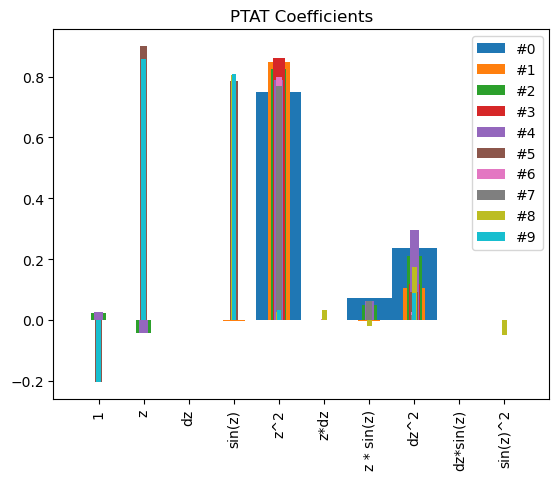

In [228]:
for i in range(10):
    plt.bar(funcs ,[float(y) for y in patient_final_xis[i].detach().numpy()], width=1/(i+1), label=f"#{i}")
plt.xticks(rotation=90)
plt.legend()
plt.title("PTAT Coefficients")

The plot above shows the coefficients for 10 runs of the sindy autoencoder. The coefficients are quite sparce and in some cases z and sin(z) got deemed quite important. Howecer also a lot of times z^2 get identified.

Text(0.5, 1.0, 'PTAT Coefficient Frequency')

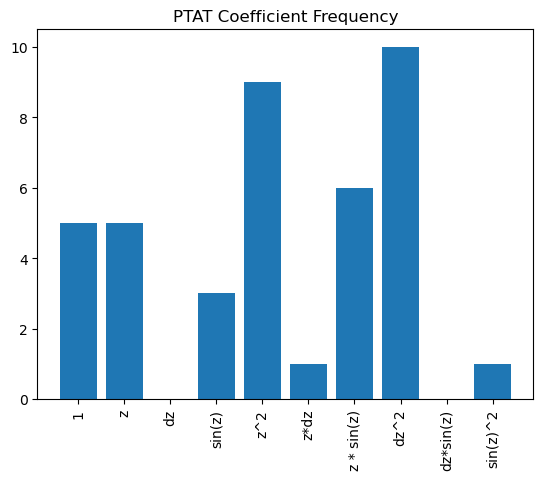

In [227]:
plt.bar(funcs, np.sum(np.array([x.detach().numpy() for x in patient_final_ups]), axis=0).reshape(10, ))
plt.xticks(rotation=90)
plt.title("PTAT Coefficient Frequency")

The plot above shows the frequency of the coefficients using PTAT. The terms sin(z) and z get identified sometimes but other terms are much more frequent.

Text(0.5, 1.0, 'Sequential Coefficients')

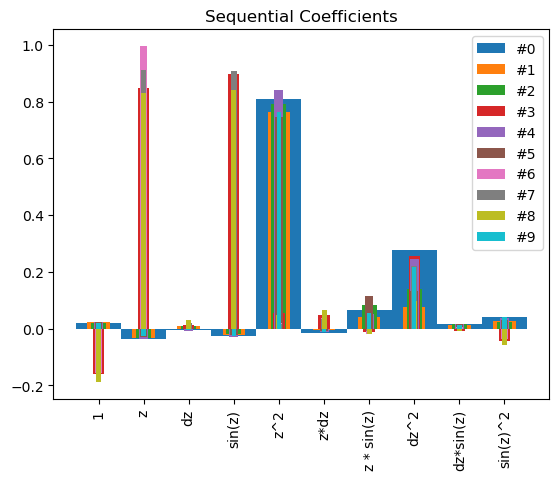

In [225]:
for i in range(10):
    plt.bar(funcs ,[float(y) for y in seq_final_xis[i].detach().numpy()], width=1/(i+1), label=f"#{i}")
plt.xticks(rotation=90)
plt.legend()
plt.title("Sequential Coefficients")

The plot above shows the coefficients for 10 runs of the sindy autoencoder with sequential thresholding. The coefficients are not sparce and in some cases z and sin(z) got deemed quite important. Howecer also a lot of times z^2 get identified.

In [215]:
np.sum(np.array([x.detach().numpy() for x in patient_final_ups]), axis=0).reshape(10, )

array([ 5,  5,  0,  3,  9,  1,  6, 10,  0,  1])

Text(0.5, 1.0, 'Sequential Coefficient Frequency')

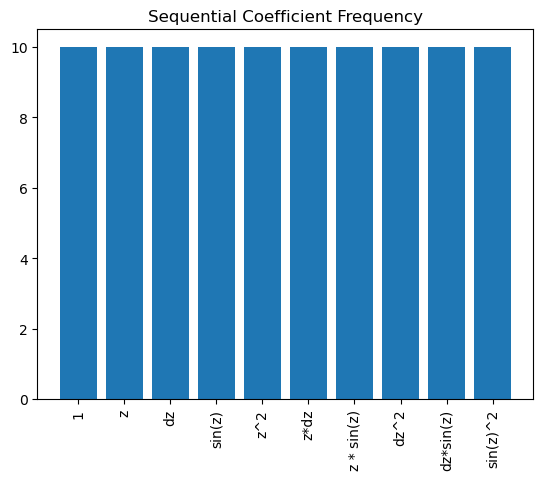

In [226]:
plt.bar(funcs, np.sum(np.array([x.detach().numpy() for x in seq_final_ups]), axis=0).reshape(10, ))
plt.xticks(rotation=90)
plt.title("Sequential Coefficient Frequency")

The plot above shows the frequency of the coefficients using sequential thresholding. This plot confirms that the sequential threshold is not working here since no terms got muted.

## Task3

<div style="color: green; font-weight: bold">The code below mainly uses the code from #2, so the same comments apply.</div>

In [236]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, Image

def embed(z, t, resolution, sigma, plot=None):



    n_samples = z.shape[0]
    y1,y2 = np.meshgrid(np.linspace(-1.5,1.5,resolution),np.linspace(0.5,-1.5,resolution))

    x = np.zeros(( n_samples, resolution, resolution))


    for i in range(n_samples):
        x[i] = np.exp(-((y1-np.sin(z[i,0]))**2 + (y2+np.cos(z[i,0]))**2)/sigma)


    fig, ax = plt.subplots()
    def update(frame):
      ax.clear()

      contour = ax.contourf(y1, y2, x[frame], 30, cmap='viridis')

      ax.set_title(f"t= {frame * 0.1:.2f}")
      ax.set_xlabel("x")


      return contour.collections
    animation = FuncAnimation(fig, update, frames=int(t//0.1), interval=100, blit=True)

    plt.close()
    animation.save('pendulum_animation.gif', writer='imagemagick')
    if plot=='show':
      display(Image(filename="pendulum_animation.gif"))

    return x




def simulate_pendulum_z(initinal_num,t):


    z = np.zeros((initinal_num,t.size,2))
    dz = np.zeros(z.shape)

    i = 0
    while (i < initinal_num):

        x =np.random.uniform(-np.pi/2, np.pi/2)
        w=np.sqrt(2*np.cos(x))
        y=np.random.uniform(-w, w)
        f=lambda z, t : [z[1], -np.sin(z[0])]
        z[i] = odeint(f, [x,y], t)
        dz[i] = np.array([f(z[i,j], t[j]) for j in range(len(t))])
        i += 1


    return z,dz





In [237]:
t = np.arange(0, 18, .1)
z, dz = simulate_pendulum_z(10,t)

MovieWriter imagemagick unavailable; using Pillow instead.


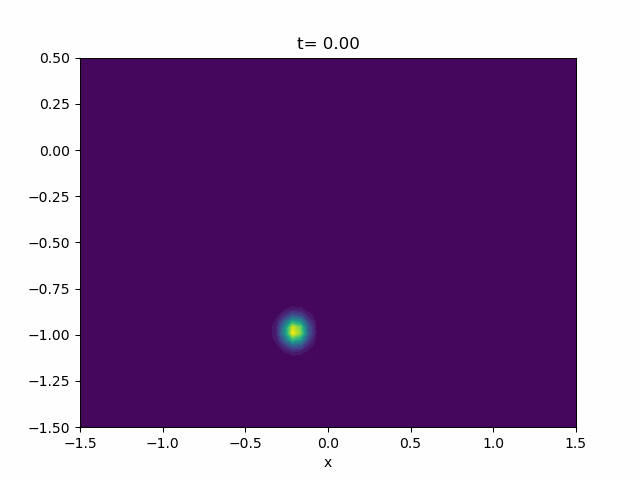

In [238]:
sigma=0.005
resolution = 64
x=embed(z[0], 8, resolution, sigma,'show')

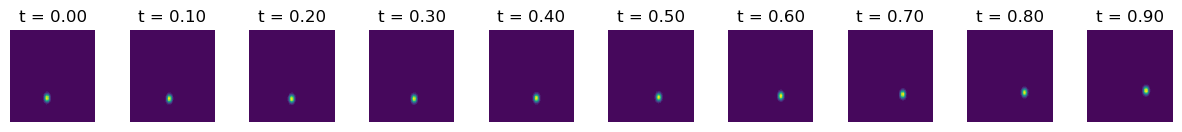

In [239]:


y1, y2 = np.meshgrid(np.linspace(-1.5, 1.5, resolution), np.linspace(0.5, -1.5, resolution))

fig, axes = plt.subplots(1, 10, figsize=(15, 1.2))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.4)

for i in range(10):

    m=1
    axes[i].contourf(y1, y2, x[i* m], 30)
    axes[i].set_title(f"t = {0.1 * m * i:.2f}")
    axes[i].axis('off')

plt.show()



In [240]:
def infinite_difference(x,dt):
  dx = np.diff(x,axis=0) / dt
  return dx

In [241]:
dt=0.1
dx=infinite_difference(x,dt)
ddx=infinite_difference(dx,dt)

In [242]:
reshaped_x= x.reshape((len(x), -1))[:len(ddx),]
reshaped_dx=dx.reshape((len(dx),-1))[:len(ddx),]
reshaped_ddx=ddx.reshape((len(ddx),-1))

In [243]:

video_data_train = np.stack([reshaped_x, reshaped_dx, reshaped_ddx], axis=-1)

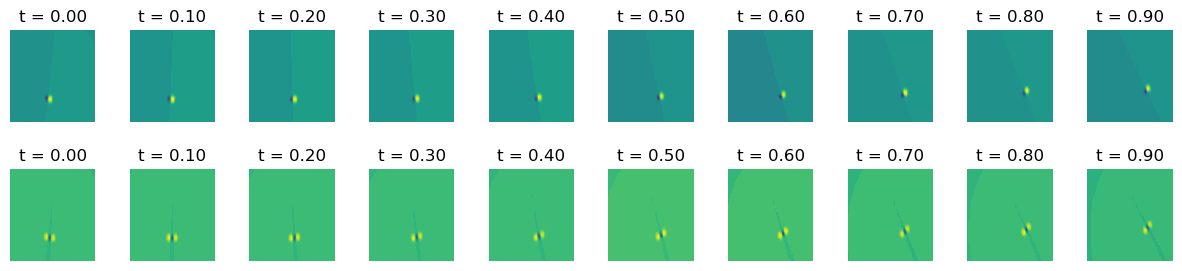

In [244]:
y1, y2 = np.meshgrid(np.linspace(-1.5, 1.5, resolution), np.linspace(0.5, -1.5, resolution))

fig, axes = plt.subplots(2, 10, figsize=(15, 3))

plt.subplots_adjust(wspace=0.4,hspace=0.5)

X=[dx,ddx]

for i in range(2):
  for j in range(10):

      axes[i,j].contourf(y1, y2, X[i][j], 30)
      axes[i,j].set_title(f"t = {0.1  * j:.2f}")
      axes[i,j].axis('off')

plt.show()

In [245]:
class Autoencoder_video(nn.Module):
    def __init__(self, input_size,code_size):
        super().__init__()
        self.input_size = input_size
        self.code_size=code_size

        self.encoder = []
        self.decoder = []
        self.encoder.append(LinearDerivatives(self.input_size, 128))
        #self.encoder.append(SigmoidDerivatives())

        #self.decoder.append(SigmoidDerivatives())
        self.decoder.append(LinearDerivatives(self.code_size, 32))
        #self.decoder.append(SigmoidDerivatives())



        self.encoder.append(LinearDerivatives(128, 64))
        self.decoder.append(LinearDerivatives(32, 64))

        self.encoder.append(SigmoidDerivatives())
        self.decoder.append(SigmoidDerivatives())

        self.encoder.append(LinearDerivatives(64, 32))
        self.decoder.append(LinearDerivatives(64,128))

        self.encoder.append(SigmoidDerivatives())
        self.decoder.append(SigmoidDerivatives())

        self.encoder.append(LinearDerivatives(32, code_size))
        self.decoder.append(LinearDerivatives(128, self.input_size))

        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)


    def encode(self, x):
        return self.encoder.forward(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))



In [246]:
class SINDyAutoencoder_video(nn.Module):
  def __init__(self, input_size, code_size):
    super().__init__()
    self.SINDy = SINDy(num_terms)
    self.autoencoder = Autoencoder_video(input_size, code_size)

  def forward(self,X):
    Z = self.autoencoder.encode(X)
    z = Z[:,:,0]
    dz = Z[:,:,1]
    ddz = Z[:,:,2]

    ddz_hat = self.SINDy.forward(z, dz)
    X_HAT = self.autoencoder.forward(X)
    x_hat = X_HAT[:,:,0]


    Z_HAT = torch.stack([z.T, dz.T, ddz_hat.reshape(dz.shape).T]).T
    ddx_hat = self.autoencoder.decode(Z_HAT)[:,:,2]
    return (x_hat, ddx_hat, ddz, ddz_hat)


In [247]:
sindy_video = SINDyAutoencoder_video(resolution**2,1)
loss_history,  coefficient_history, upsilon_history = train_sindy_autoencoder(sindy_video, video_data_train, 3000, 1E-5, 5E-4, 5E-5, refinement_epoch = 5000, thresholding = "patient", P=1000, b= 0.002, a = 0.1, S = 500, )

Epoch 0: Total Loss = 0.051508400589227676, X-Loss: 0.04084400087594986, DDZ-Loss: 8.295634269714355, DDX-Loss: 20.299636840820312, L1-Loss: 9.98004150390625
Epoch 100: Total Loss = 0.011380189098417759, X-Loss: 0.0011496574152261019, DDZ-Loss: 0.0053067272529006, DDX-Loss: 20.29926872253418, L1-Loss: 8.063186645507812
Epoch 200: Total Loss = 0.011357270181179047, X-Loss: 0.0011484995484352112, DDZ-Loss: 0.0029935999773442745, DDX-Loss: 20.299283981323242, L1-Loss: 5.897746562957764
Epoch 300: Total Loss = 0.011321027763187885, X-Loss: 0.0011345935054123402, DDZ-Loss: 0.024948563426733017, DDX-Loss: 20.29938507080078, L1-Loss: 3.5493252277374268
Epoch 400: Total Loss = 0.01116979867219925, X-Loss: 0.0009995694272220135, DDZ-Loss: 0.037878166884183884, DDX-Loss: 20.29876136779785, L1-Loss: 1.8954493999481201
Epoch 500: Total Loss = 0.01111292652785778, X-Loss: 0.0009603850776329637, DDZ-Loss: 0.034083042293787, DDX-Loss: 20.287446975708008, L1-Loss: 0.7113761901855469
Epoch 600: Total L

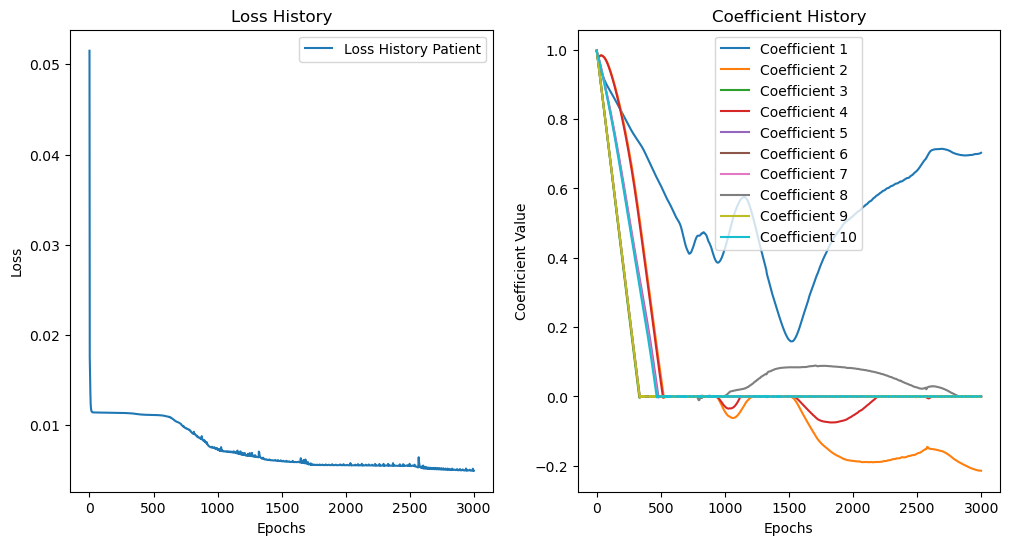

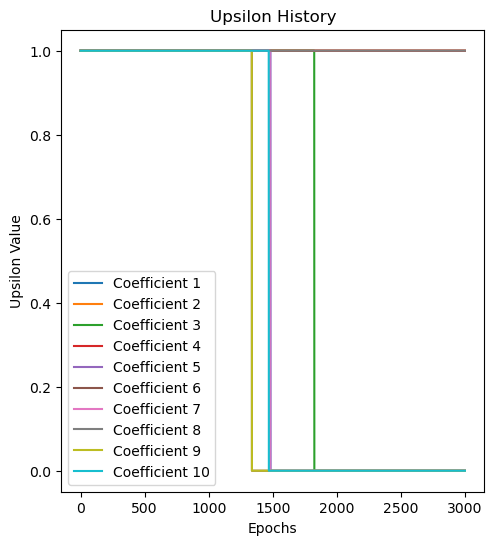

In [248]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss History Patient')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

# Plotting the coefficient history
plt.subplot(1, 2, 2)
coeff_array = np.array(coefficient_history)  # Assuming coefficient_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Coefficient Value')
plt.title('Coefficient History')
plt.legend()
plt.show()

# Plotting the coefficient history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
coeff_array = np.array(upsilon_history)  # Assuming upsilon_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Upsilon Value')
plt.title('Upsilon History')
plt.legend()
plt.show()


In [249]:
sindy_video = SINDyAutoencoder_video(resolution**2,1)
loss_history,  coefficient_history, upsilon_history = train_sindy_autoencoder(sindy_video, video_data_train, 3000, 1E-5, 5E-4, 5E-5, refinement_epoch = 5000, thresholding = "seqiential", P=1000, b= 0.002, a = 0.1, S = 500, )

Epoch 0: Total Loss = 0.052557360380887985, X-Loss: 0.042280860245227814, DDZ-Loss: 0.5406511425971985, DDX-Loss: 20.299297332763672, L1-Loss: 9.981855392456055
Epoch 100: Total Loss = 0.011379324831068516, X-Loss: 0.0011498589301481843, DDZ-Loss: 0.003142279339954257, DDX-Loss: 20.299280166625977, L1-Loss: 7.966766834259033
Epoch 200: Total Loss = 0.011353668756783009, X-Loss: 0.001148540643043816, DDZ-Loss: 0.002573434030637145, DDX-Loss: 20.299280166625977, L1-Loss: 5.535843372344971
Epoch 300: Total Loss = 0.011298494413495064, X-Loss: 0.0011169937206432223, DDZ-Loss: 0.037265144288539886, DDX-Loss: 20.29938507080078, L1-Loss: 2.994368553161621
Epoch 400: Total Loss = 0.01114065945148468, X-Loss: 0.0009754650527611375, DDZ-Loss: 0.02995295450091362, DDX-Loss: 20.299440383911133, L1-Loss: 1.3975837230682373
Epoch 500: Total Loss = 0.011119084432721138, X-Loss: 0.0009626267710700631, DDZ-Loss: 0.032506272196769714, DDX-Loss: 20.297639846801758, L1-Loss: 0.6011584997177124
Epoch 600: 

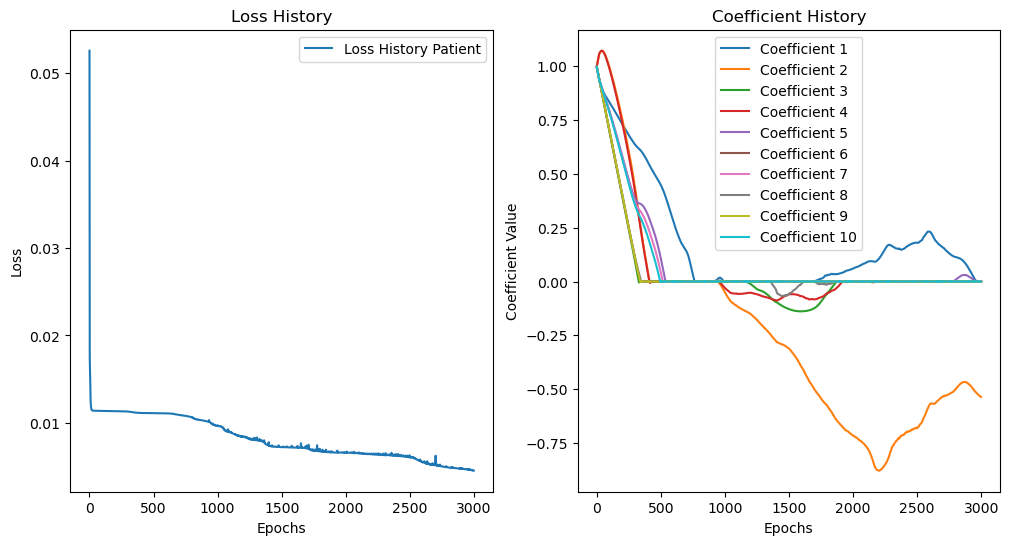

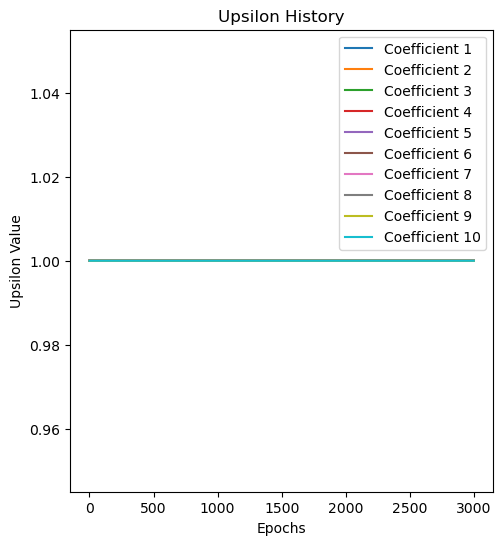

In [250]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss History Patient')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

# Plotting the coefficient history
plt.subplot(1, 2, 2)
coeff_array = np.array(coefficient_history)  # Assuming coefficient_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Coefficient Value')
plt.title('Coefficient History')
plt.legend()
plt.show()

# Plotting the coefficient history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
coeff_array = np.array(upsilon_history)  # Assuming upsilon_history is a list of numpy arrays
for i in range(coeff_array.shape[1]):
    plt.plot(coeff_array[:, i, 0], label=f'Coefficient {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Upsilon Value')
plt.title('Upsilon History')
plt.legend()
plt.show()
